* This notebook was made to look at the alongshore, cross-starit transport of fresh water, total water amount of each run.

In [1]:
import numpy as np
import netCDF4 as nc
from salishsea_tools import (
    nc_tools,
    viz_tools,
    tidetools,
    stormtools
)
import datetime, os
from glob import glob
from nowcast import figures
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from R_mixStuff import sites
from R_mixStuff import strings
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})

In [2]:
transects = {'1':{'jst':55, 'ist':25,'jen':56,'ien':80},
            '2':{'jst':25, 'ist':25,'jen':26,'ien':75},
            '3':{'jst':25, 'ist':25,'jen':56,'ien':26},
            '4':{'jst':37, 'ist':72,'jen':45,'ien':73},
            '5':{'jst':120, 'ist':138,'jen':121,'ien':139}}

In [3]:
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
X = grid6.variables['nav_lon'][380:510,240:397]
Y = grid6.variables['nav_lat'][380:510,240:397]
bathy = grid6.variables['Bathymetry'][380:510,240:397]

In [4]:
## mask
mesh = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/mesh_mask.nc')
tmask = mesh.variables['tmask'][0,:,380:510,240:397]
umask = mesh.variables['umask'][0,:,380:510,240:397]
vmask = mesh.variables['vmask'][0,:,380:510,240:397]
e3u = mesh.variables['e3u'][0,:,380:510,240:397]
e3v = mesh.variables['e3v'][0,:,380:510,240:397]
e3t = mesh.variables['e3t'][0,:,380:510,240:397]
e2t = mesh.variables['e2t'][0,380:510,240:397]
e1t = mesh.variables['e1t'][0,380:510,240:397]
np_mask = np.abs(1-tmask) 

(48.95, 49.7)

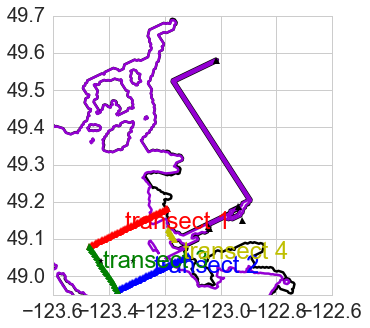

In [24]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
viz_tools.plot_coastline(ax, grid6, coords = 'map')
viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 5,color = 'DarkViolet')
ax.plot(X[55,25:80],Y[55,25:80],'r^')
ax.plot(X[25,25:75],Y[25,25:75],'b^')
ax.plot(X[25:56,25],Y[25:56,25],'g^')
ax.plot(X[37:45,72],Y[37:45,72],'y^')
ax.plot(X[34:36,94],Y[34:36,94],'k^')
ax.plot(X[120:121,155],Y[120:121,155],'k^')
ax.plot(X[38,117],Y[38,117],'k^')
ax.plot(X[30,114],Y[30,114],'k^')
ax.plot(X[sites['VENUS Central']['j'],sites['VENUS Central']['i']],\
         Y[sites['VENUS Central']['j'],sites['VENUS Central']['i']],'k*')
ax.plot(X[sites['VENUS East']['j'],sites['VENUS East']['i']],\
         Y[sites['VENUS East']['j'],sites['VENUS East']['i']],'k*')
ax.annotate ('transect 1',(X[55,50],Y[55,50]), xycoords="data",color = 'r')
ax.annotate ('transect 2',(X[25,50],Y[25,50]), xycoords="data",color = 'b')
ax.annotate ('transect 3',(X[40,25],Y[40,25]), xycoords="data",color = 'g')
ax.annotate ('transect 4',(X[25,70],Y[25,70]), xycoords="data",color = 'y')
ax.set_xlim([-123.6,-122.6])
ax.set_ylim([48.95,49.7])
#ax.set_ylim([49.4,49.7])

In [22]:
bathy[38,117]

masked

In [23]:
bathy[30,114]

masked

In [6]:
## load salinity into a dict
paths = ['Oct2014OnlyRiver','Oct2014notides','Oct2014nowind','Oct2014nof','Oct2014combineall']
base='/data/jieliu/MEOPAR/SurfaceCurrent/'
file_patternT = 'oct2014*_T.nc'
file_patternU = 'oct2014*_U.nc'
file_patternV = 'oct2014*_V.nc'
U = {}; V={}; S={};ssh = {}
for pa in paths:
    pathT = glob(os.path.join(base,pa, file_patternT))
    pathU = glob(os.path.join(base,pa, file_patternU))
    pathV = glob(os.path.join(base,pa, file_patternV))
    fU = nc.Dataset(pathU[0],'r');
    U[pa] = fU.variables['vozocrtx']
    fV = nc.Dataset(pathV[0],'r');
    V[pa] = fV.variables['vomecrty']
    depU = fU.variables['depthu']
    depV = fV.variables['depthv']
    fT = nc.Dataset(pathT[0],'r');
    S[pa] = fT.variables['vosaline']
    lon = fT.variables['nav_lon'] 
    lat = fT.variables['nav_lat']
    ssh[pa] = fT.variables['sossheig']
    time_counter = fT.variables['time_counter']

In [7]:
def transport_time (S,U,V,ssh,lon,lat,depU,depV,tran,string ='specific time',fresh_flag = False):
    """This subfunction was made only to calculate the 
       transport/freshwater transport of a transect at the specific time"""
    trans = {}; trans_surf = {}; trans_total ={}
    if tran =='3' or tran =='4': ## cross-shelf transport
        for pa in paths:
            trans[pa] = {};
            for t in strings[string]:
                trans[pa][t] = np.zeros([depU.shape[0],np.arange(transects[tran]['jen']-transects[tran]['jst']).shape[0]])
                for z in np.arange(depU.shape[0]):
                    for j in np.arange(transects[tran]['jen']-transects[tran]['jst']):
                        d = e2t[j+transects[tran]['jst'],transects[tran]['ist']]
                        if fresh_flag == False:
                            ratio = 1
                        else:
                            ratio = (30 - S[pa][t][z,j,0])/30
                        adj_ssh = 1+ssh[pa][strings[string][t],j+transects[tran]['jst'],transects[tran]['ist']]\
                        /np.sum(e3t[:,j+transects[tran]['jst'],\
                        transects[tran]['ist']]*tmask[:,j+transects[tran]['jst'],transects[tran]['ist']])
                        
                        trans[pa][t][z,j] = U[pa][t][z,j,0]*d*e3t[z,j+transects[tran]['jst'],transects[tran]['ist']]*adj_ssh*ratio
    else: ## along-shore transport
        for pa in paths:
            trans[pa] = {};
            for t in strings[string]:
                trans[pa][t] = np.zeros([depV.shape[0],np.arange(transects[tran]['ien']-transects[tran]['ist']).shape[0]]);
                for z in np.arange(depV.shape[0]):
                    for i in np.arange(transects[tran]['ien']-transects[tran]['ist']):
                        d =  e1t[transects[tran]['jst'],i+transects[tran]['ist']]
                        if fresh_flag == False:
                            ratio = 1
                        else:
                            ratio = (30 - S[pa][t][z,0,i])/30

                        adj_ssh = 1+ssh[pa][strings[string][t],transects[tran]['jst'],i+transects[tran]['ist']]\
                        /np.sum(e3t[:,transects[tran]['jst'],i+transects[tran]['ist']]*tmask[:,transects[tran]['jst'],i+transects[tran]['ist']])
                        
                        trans[pa][t][z,i] = V[pa][t][z,0,i]*d*e3t[z,transects[tran]['jst'],i+transects[tran]['ist']]*adj_ssh*ratio ## shape of [40,54]
    ## surface and total transport in the dict
    for pa in paths:
        trans_surf[pa] = {}; trans_total[pa] ={}
        for t in strings[string]:
            trans_surf[pa][t] = np.nansum(trans[pa][t],axis = 1)[0]
            trans_total[pa][t] = np.nansum(trans[pa][t])
 
    return trans, trans_surf,trans_total

In [9]:
def transport_calculate(S,U,V,ssh,lon,lat,depU,depV,tran,string ='specific time',\
                         fresh_flag = False,y0lim =6e5, y1lim = 6000):
    """ This function was made to calculate the total transport (False)
        or fresh water transport (True) in the entire water column at specific 
        time or averaged low/high tides along the north/south cross-strait
        transect or along-shore transect .
    """
    fig = plt.figure(figsize=(20,12))
    gs = gridspec.GridSpec(2, 2,width_ratios=[1,2], height_ratios=[1, 1])  
    gs.update(hspace=0.15, wspace=0.15)
    UU = {}; VV= {};SS={}
    jinds = np.arange(transects[tran]['jst'],transects[tran]['jen']+1)
    iinds = np.arange(transects[tran]['ist'],transects[tran]['ien']+1)
    if string == 'specific time' or string =='current time':
        for pa in paths:
            UU[pa] = {}; VV[pa] = {}; SS[pa] = {}
        for t in strings[string]:
            for pa in paths:
                SS[pa][t] = S[pa][strings[string][t],:,jinds,iinds]          
                mask=np_mask[:,jinds[0]:jinds[-1]+1,iinds[0]:iinds[-1]+1]
                SS[pa][t] = np.ma.masked_array(SS[pa][t],mask=mask) ## mask sal=0 by tmask    
                
                               
                UU[pa][t],VV[pa][t] = viz_tools.unstagger(U[pa][strings[string][t],:,jinds,iinds],\
                                          V[pa][strings[string][t],:,jinds,iinds])
                #rotate
                #theta = np.pi*29/180
                #UU[pa][t] = u*np.cos(theta) - v*np.sin(theta)
                #VV[pa][t] = u*np.sin(theta) +v*np.cos(theta)
        trans,trans_sur,trans_to = transport_time(SS,UU,VV,ssh,lon,lat,depU,depV,tran,string = string,\
                                                 fresh_flag = fresh_flag) ## get surface/total transport
        ## location
        ax = fig.add_subplot(gs[0,0])
        viz_tools.plot_coastline(ax, grid6, coords = 'map')
        viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 5,color = 'DarkViolet')
        ax.set_xlim([-123.6,-122.9])
        ax.set_ylim([48.95,49.4])
        if tran =='3' or tran =='4':
            ax.plot(X[transects[tran]['jst']:transects[tran]['jen'],transects[tran]['ist']],\
            Y[transects[tran]['jst']:transects[tran]['jen'],transects[tran]['ist']],'ro')
        else:
            ax.plot(X[transects[tran]['jst'],transects[tran]['ist']:transects[tran]['ien']],\
            Y[transects[tran]['jst'],transects[tran]['ist']:transects[tran]['ien']],'ro')
        ax.annotate ('transect '+tran,(X[transects[tran]['jst'],transects[tran]['ist']],\
                    Y[transects[tran]['jst'],transects[tran]['ist']]), xycoords="data",color = 'r')
        ## total transport
        ax = fig.add_subplot(gs[0,1])
        cs = ['g','r','m','k','y']
        transurf = {}; trantotal = {} ## turn a dict to list
        for pa in paths:
            transurf[pa] = []; trantotal[pa] = [];
            transurf[pa] = [trans_sur[pa]['t_ind_low'],trans_sur[pa]['middle of flood'],trans_sur[pa]['t_ind_high']]
            trantotal[pa] = [trans_to[pa]['t_ind_low'],trans_to[pa]['middle of flood'],trans_to[pa]['t_ind_high']]
            
        for pa,c in zip(paths,cs):
            ax.plot(trantotal[pa],'-*',color = c,label = pa)
            print (pa,trantotal[pa])
        ax.set_ylim([-y0lim,y0lim])
        ## surface transport
        ax = fig.add_subplot(gs[1,1]) 
        for pa,c in zip(paths,cs):
            ax.plot(transurf[pa],'-.*',color = c,label = pa)
        ax.set_ylim([-y1lim,y1lim]) 
        for ax in [fig.add_subplot(gs[0,1]),fig.add_subplot(gs[1,1])]:
            ax.legend(loc = 'best')
            ax.grid('on')
            plt.setp(ax, xticks=[0, 1, 2], xticklabels=['low tide','middle of flood','high tide'])
            if fresh_flag == False:
                ax.set_ylabel('Total transport [m^3/s]')
            else:
                ax.set_ylabel('Fresh water transport [m^3/s]')
    return fig

In [10]:
def transport_calculate_general(S,U,V,ssh,lon,lat,depU,depV,tran,t_st,t_en,fresh_flag = False,\
                                y0lim =6e5, y1lim = 6000):
    """Same as transport_calculate function, but focus on a continous time period rather 
    than a specific time"""
    UU = {}; VV= {};SS={}
    jinds = np.arange(transects[tran]['jst'],transects[tran]['jen']+1)
    iinds = np.arange(transects[tran]['ist'],transects[tran]['ien']+1)
    for pa in paths:
        SS[pa] = np.zeros([time_counter.shape[0],depU.shape[0],jinds.shape[0],iinds.shape[0]])
        UU[pa] = np.zeros([time_counter.shape[0],depU.shape[0],jinds.shape[0]-1,iinds.shape[0]-1])
        VV[pa] = np.zeros([time_counter.shape[0],depV.shape[0],jinds.shape[0]-1,iinds.shape[0]-1])
        for t in np.arange(t_st,t_en+1):
            SS[pa][t] = S[pa][t,:,jinds,iinds]    
            mask=np_mask[:,jinds[0]:jinds[-1]+1,iinds[0]:iinds[-1]+1]
            SS[pa][t] = np.ma.masked_array(SS[pa][t],mask=mask) ## mask sal=0 by tmask 
                    
                               
            UU[pa][t],VV[pa][t] = viz_tools.unstagger(U[pa][t,:,jinds,iinds],\
                                      V[pa][t,:,jinds,iinds])
            #rotate
            #theta = np.pi*29/180
            #UU[pa][t] = u*np.cos(theta) - v*np.sin(theta)
            #VV[pa][t] = u*np.sin(theta) +v*np.cos(theta)
    trans,trans_sur,trans_to = transport_time_general(SS,UU,VV,ssh,lon,lat,depU,depV,tran,t_st,t_en,\
                                                 fresh_flag = fresh_flag) ## get surface/total transport
        ## location
    return trans,trans_sur,trans_to

In [11]:
def transport_time_general(S,U,V,ssh,lon,lat,depU,depV,tran,t_st,t_en,fresh_flag = False):
    """This function was made to calculate total 
    transport/fresh water transport during a continuous 
    period, rather than the specific time """
    trans = {}; trans_surf = {}; trans_total ={}
    if tran =='3' or tran =='4' or tran =='5': ## cross-shelf transport
        for pa in paths:
            trans[pa] = np.zeros([time_counter.shape[0],depU.shape[0],np.arange(transects[tran]['jen']-transects[tran]['jst']).shape[0]])
            for t in np.arange(t_st,t_en+1):
                for z in np.arange(depU.shape[0]):
                    for j in np.arange(transects[tran]['jen']-transects[tran]['jst']):
                        d = e2t[j+transects[tran]['jst'],transects[tran]['ist']]
                        if fresh_flag == False:
                            ratio = 1
                        else:
                            ratio = (30 - S[pa][t,z,j,0])/30
                        adj_ssh = 1+ssh[pa][t,j+transects[tran]['jst'],transects[tran]['ist']]\
                        /np.sum(e3t[:,j+transects[tran]['jst'],\
                        transects[tran]['ist']]*tmask[:,j+transects[tran]['jst'],transects[tran]['ist']])

                        trans[pa][t,z,j] = U[pa][t,z,j,0]*d*e3t[z,j+transects[tran]['jst'],transects[tran]['ist']]*adj_ssh*ratio
    else: ## along-shore transport
        for pa in paths:
            trans[pa]= np.zeros([time_counter.shape[0],depV.shape[0],np.arange(transects[tran]['ien']-transects[tran]['ist']).shape[0]]);
            for t in np.arange(t_st,t_en+1):
                for z in np.arange(depV.shape[0]):
                    for i in np.arange(transects[tran]['ien']-transects[tran]['ist']):
                        d = e1t[transects[tran]['jst'],i+transects[tran]['ist']]
                        if fresh_flag == False:
                            ratio = 1
                        else:
                            ratio = (30 - S[pa][t,z,0,i])/30

                        adj_ssh = 1+ssh[pa][t,transects[tran]['jst'],i+transects[tran]['ist']]\
                        /np.sum(e3t[:,transects[tran]['jst'],i+transects[tran]['ist']]*tmask[:,transects[tran]['jst'],i+transects[tran]['ist']])

                        trans[pa][t,z,i] = V[pa][t,z,0,i]*d*e3t[z,transects[tran]['jst'],i+transects[tran]['ist']]*adj_ssh*ratio ## shape of [40,54]
    ## surface and total transport in the dict
    for pa in paths:
        trans_surf[pa] = np.nansum(trans[pa][t_st:t_en+1,0,:],axis = 1)
        trans_total[pa] = np.nansum(np.nansum(trans[pa][t_st:t_en+1],axis = 1),axis = 1)
 
    return trans, trans_surf,trans_total

In [12]:
def plot_series_transport(S,U,V,ssh,lon,lat,depU,depV,tran,tst,ten,fresh_flag = True,y1lim = 8000,y2lim = 2500):
    """This function was made to plot the 
        fresh water transport/total water transport
        over a period of time"""
    trans,trans_surf,trans_to = transport_calculate_general(S,U,V,ssh,lon,lat,depU,depV,tran,tst,ten,\
                                                                   fresh_flag = fresh_flag)
    fig, axs = plt.subplots(3,1,figsize = (19,14))
    ax = axs[0]
    for pa in paths:
        ax.plot(ssh[pa][tst:ten+1,86,89],label = pa)
    ax.set_ylabel('ssh at PA [m]')
    ax = axs[1]
    for pa in paths:
        ax.plot(trans_to[pa],'-^',label = pa)
        ax.legend(loc = 'best')
        if fresh_flag == True:
            ax.set_ylabel('total fresh water flux')
        else:
            ax.set_ylabel('total volume flux')
    ax.set_ylim([-y1lim,y1lim])
    ax = axs[2]
    for pa in paths:
        ax.plot(trans_surf[pa],'-*',label = pa)
        ax.legend(loc = 'best')
        if fresh_flag ==True:
            ax.set_ylabel('surface fresh water flux')
        else:
            ax.set_ylabel('surface volume flux')
        ax.set_xlabel('time')
    ax.set_ylim([-y2lim,y2lim])
    for ax in axs:
        ax.grid('on')
    print ('max transport of Onlyriver case is ', np.max(abs(trans_to['Oct2014OnlyRiver'])))
    ## intergral the freshwater/total volumn over time of no wind case
    pa = 'Oct2014nowind';
    OverTime = 0
    for i in np.arange(ten-tst):
        OverTime = trans_to[pa][i] * 3600 + OverTime
    print ('Integral over time of no wind case is ', OverTime)

In [13]:
def uvs_contour(U,V,S,depU,depV,pa,tran,ind,string = 'specific time',st = 't_ind_high'):
    """This function was made to look at the u,v contour along transect
     at a specific time"""
    fig,axs =plt.subplots(3,1,figsize = (16,14))
    UU = {}; VV= {}; SS={}
    jinds = np.arange(transects[tran]['jst'],transects[tran]['jen']+1)
    iinds = np.arange(transects[tran]['ist'],transects[tran]['ien']+1)
    UU[pa] = {}; VV[pa] = {}; SS[pa] = {};

    SS[pa][st] = S[pa][strings[string][st],:,jinds,iinds]
    mask=np_mask[:,jinds[0]:jinds[-1]+1,iinds[0]:iinds[-1]+1]
    SS[pa][st] = np.ma.masked_array(SS[pa][st],mask=mask) ## mask sal=0 by tmask    
    u,v = viz_tools.unstagger(U[pa][strings[string][st],:,jinds,iinds],\
                                          V[pa][strings[string][st],:,jinds,iinds])
    #rotate
    theta = np.pi*29/180
    UU[pa][st] = u*np.cos(theta) - v*np.sin(theta)
    VV[pa][st] = u*np.sin(theta) +v*np.cos(theta)
    if tran == '1' or tran =='2':
        islices = np.arange(transects[tran]['ien'] - transects[tran]['ist'])
        dep = depV
        VV[pa][st] = VV[pa][st][:,0,:]
        UU[pa][st] = UU[pa][st][:,0,:]
        SS[pa][st] =  SS[pa][st][:,0,:][:,:-1]
    else:
        islices = np.arange(transects[tran]['jen'] - transects[tran]['jst'])
        dep = depU
        UU[pa][st] = UU[pa][st][:,:,0]
        VV[pa][st] = VV[pa][st][:,:,0]
        SS[pa][st] =  SS[pa][st][:,:,0][:,:-1]

    ax = axs[0]
    cmap = plt.get_cmap('jet')
    cmap.set_bad('burlywood')
    mesh = ax.pcolormesh(islices, dep[:], SS[pa][st], cmap = cmap,vmin=0, vmax=30)
    ax.set_title('Salinity along trasect '+tran+pa)
    cbar = fig.colorbar(mesh, ax=ax)
    cbar.set_label('Practical Salinity')
    for ax, ob,tl in zip ([axs[1],axs[2]], [UU[pa][st],VV[pa][st]],['U','V']):
        mesh = ax.contourf(islices,dep[:],ob, np.arange(-1.0,1.0+.1,.1),cmap = 'bwr')
        cbar = fig.colorbar(mesh, ax=ax)
        cbar.set_label(tl+' Velocity [m/s]')
        ax.set_title(tl +' along transect ' +tran+pa)        
    for ax in axs:
        ax.set_ylim([dep[ind], 0])
        ax.set_ylabel('depth [m]')
        ax.set_xlim([islices[0],islices[-1]])
        ax.set_xlabel('slices')

# Onlyriver

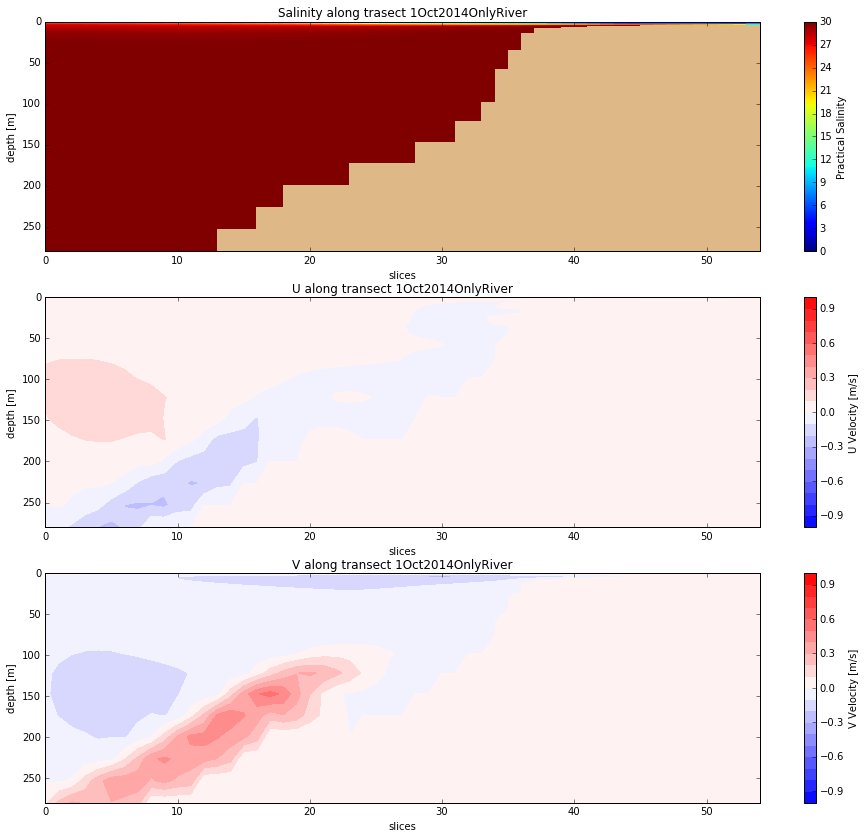

In [13]:
uvs_contour(U,V,S,depU,depV,'Oct2014OnlyRiver','1',33,st = 't_ind_high')

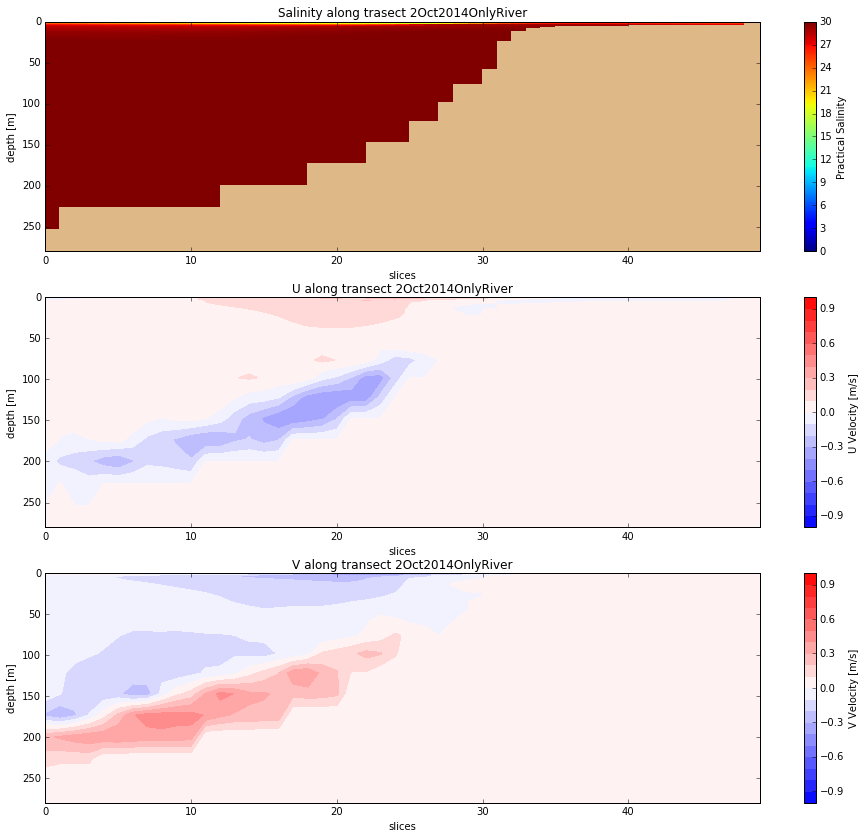

In [14]:
uvs_contour(U,V,S,depU,depV,'Oct2014OnlyRiver','2',33,st = 't_ind_high')

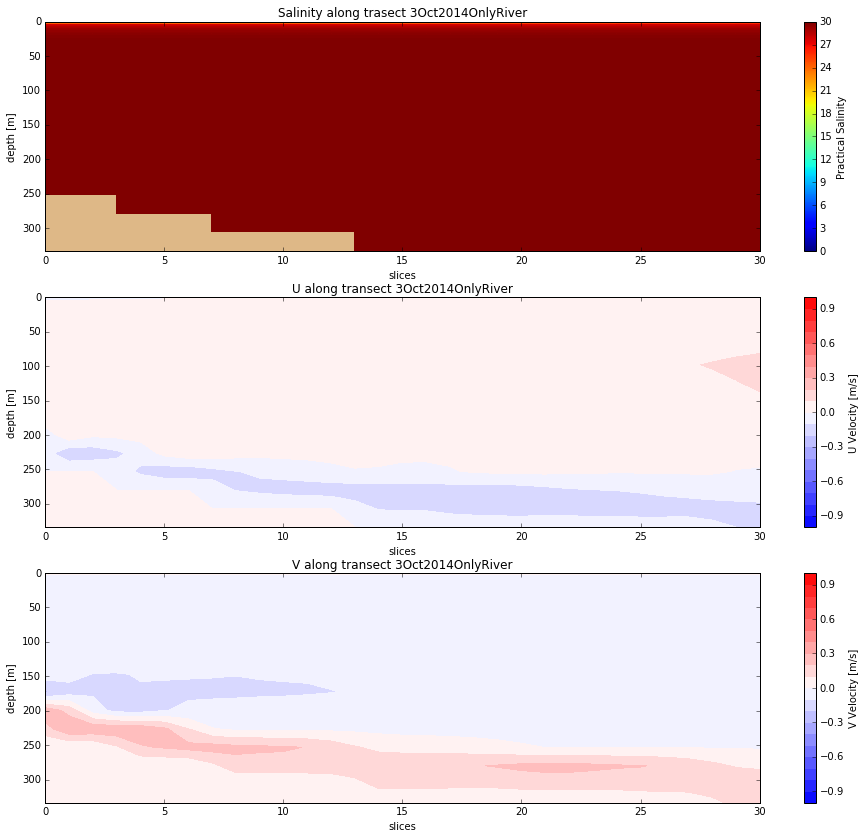

In [15]:
uvs_contour(U,V,S,depU,depV,'Oct2014OnlyRiver','3',35,st = 't_ind_high')

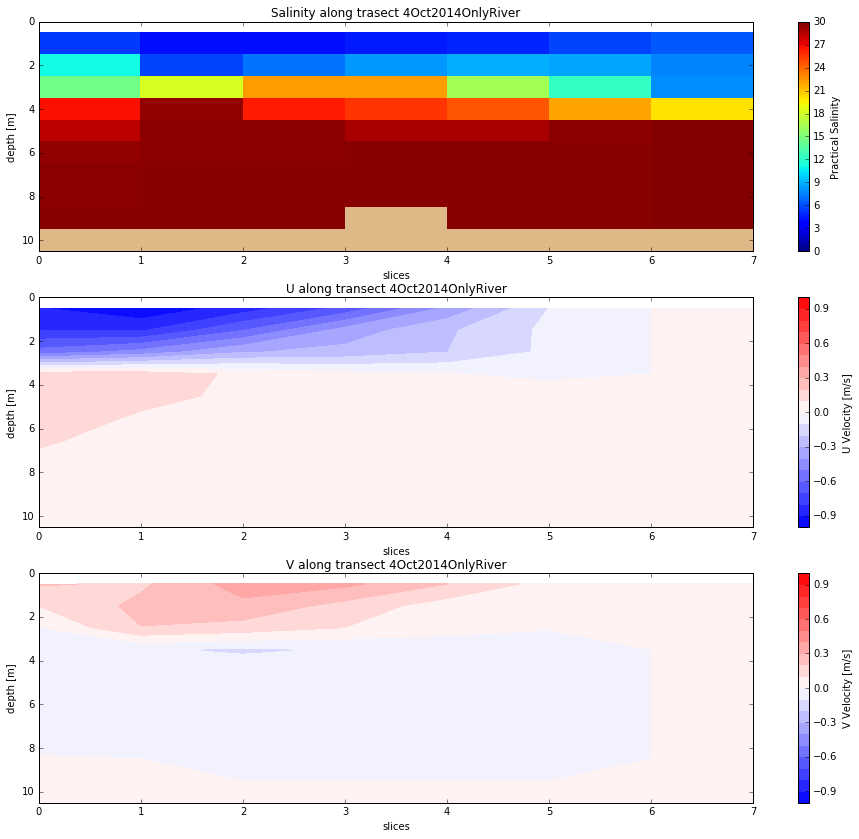

In [16]:
uvs_contour(U,V,S,depU,depV,'Oct2014OnlyRiver','4',10,st = 't_ind_high')

# Nowinds

* transect1

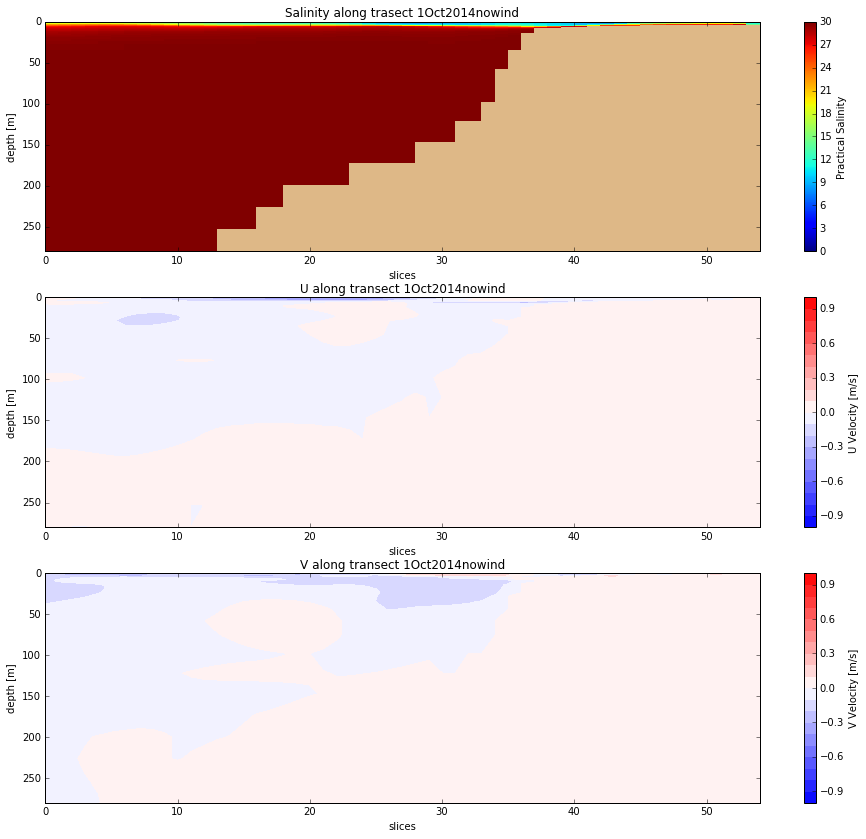

In [17]:
uvs_contour(U,V,S,depU,depV,'Oct2014nowind','1',33,st = 't_ind_low')

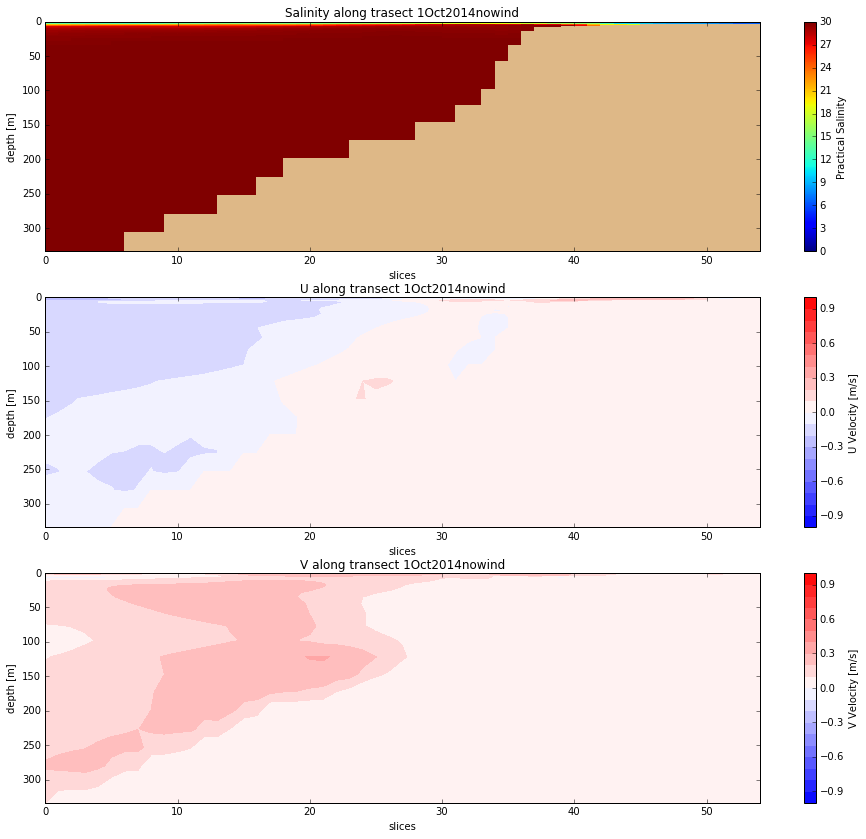

In [18]:
uvs_contour(U,V,S,depU,depV,'Oct2014nowind','1',35,st = 'middle of flood')

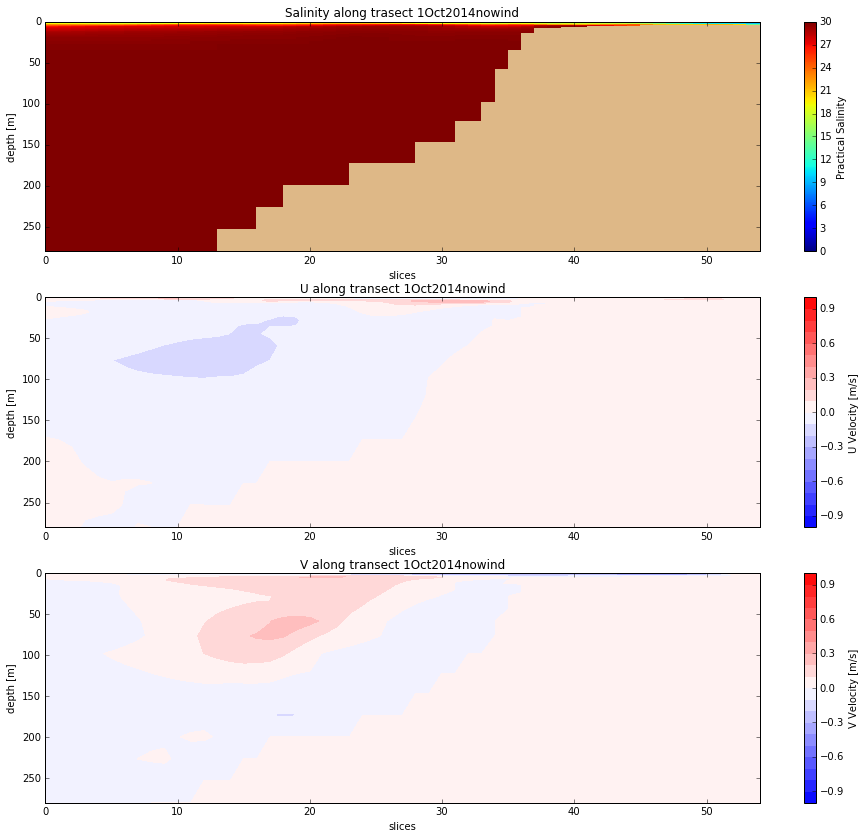

In [19]:
uvs_contour(U,V,S,depU,depV,'Oct2014nowind','1',33,st = 't_ind_high')

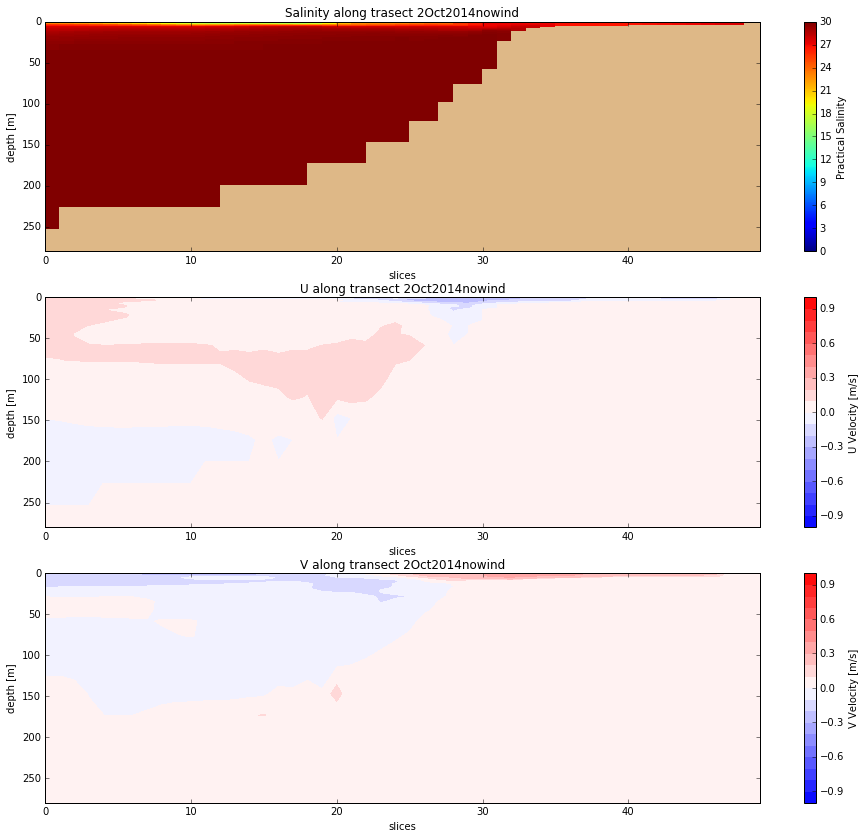

In [20]:
uvs_contour(U,V,S,depU,depV,'Oct2014nowind','2',33,st = 't_ind_low')

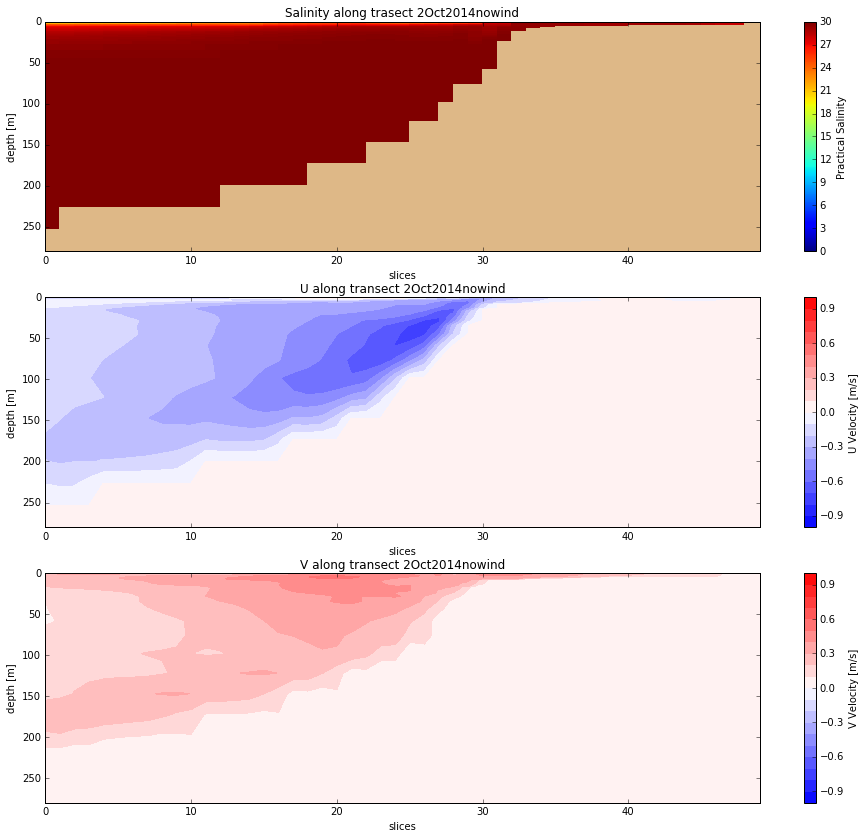

In [21]:
uvs_contour(U,V,S,depU,depV,'Oct2014nowind','2',33,st = 'middle of flood')

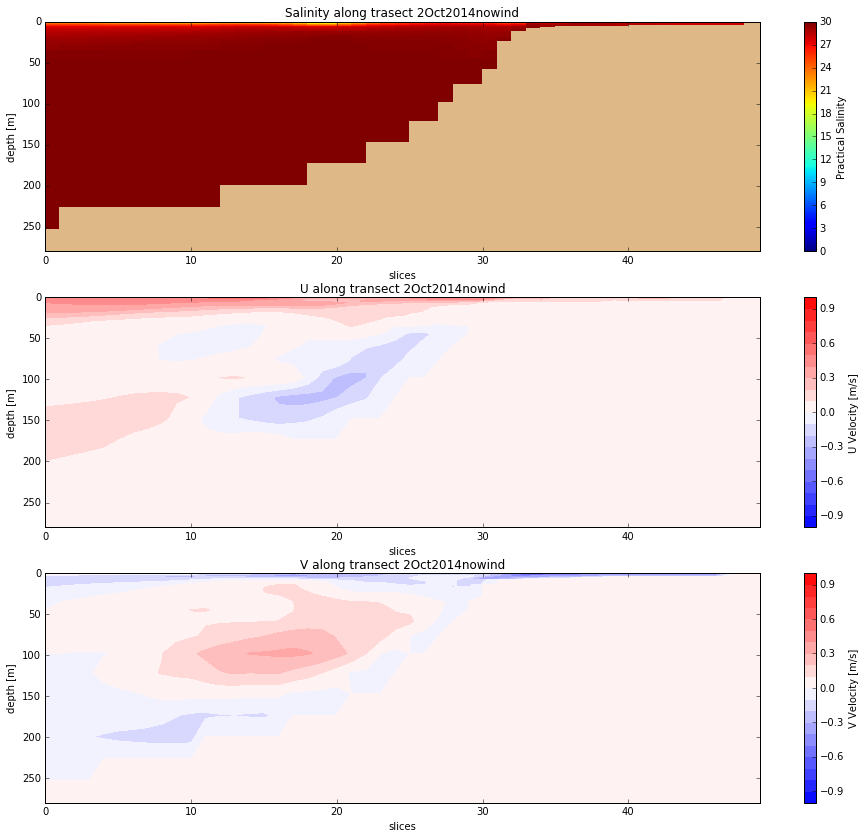

In [22]:
uvs_contour(U,V,S,depU,depV,'Oct2014nowind','2',33,st = 't_ind_high')

* transect 3

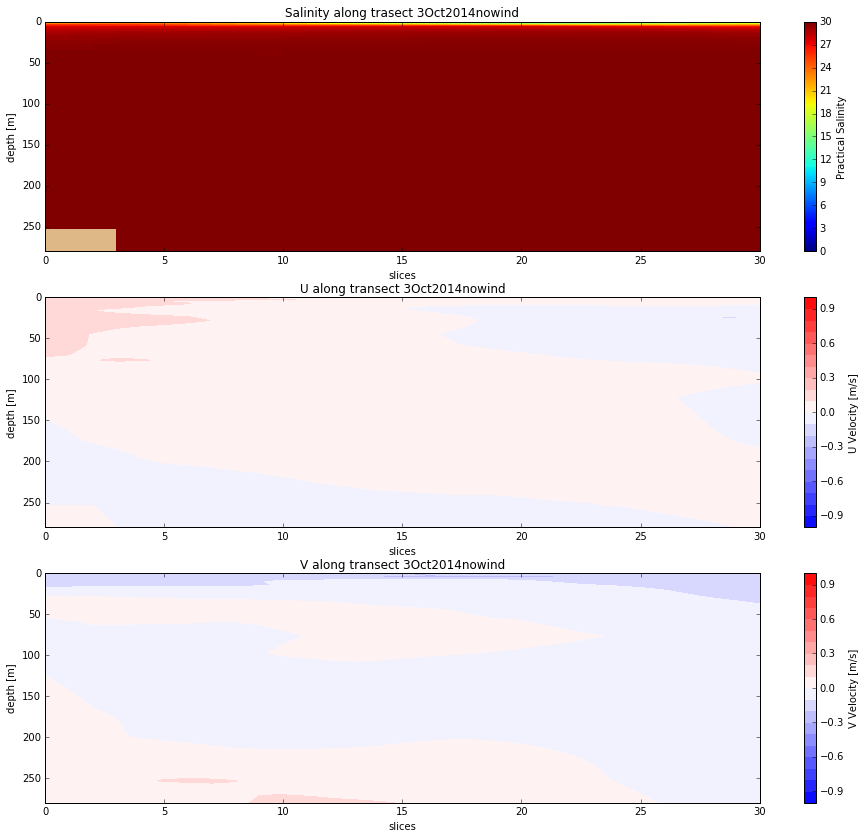

In [23]:
uvs_contour(U,V,S,depU,depV,'Oct2014nowind','3',33,st = 't_ind_low')

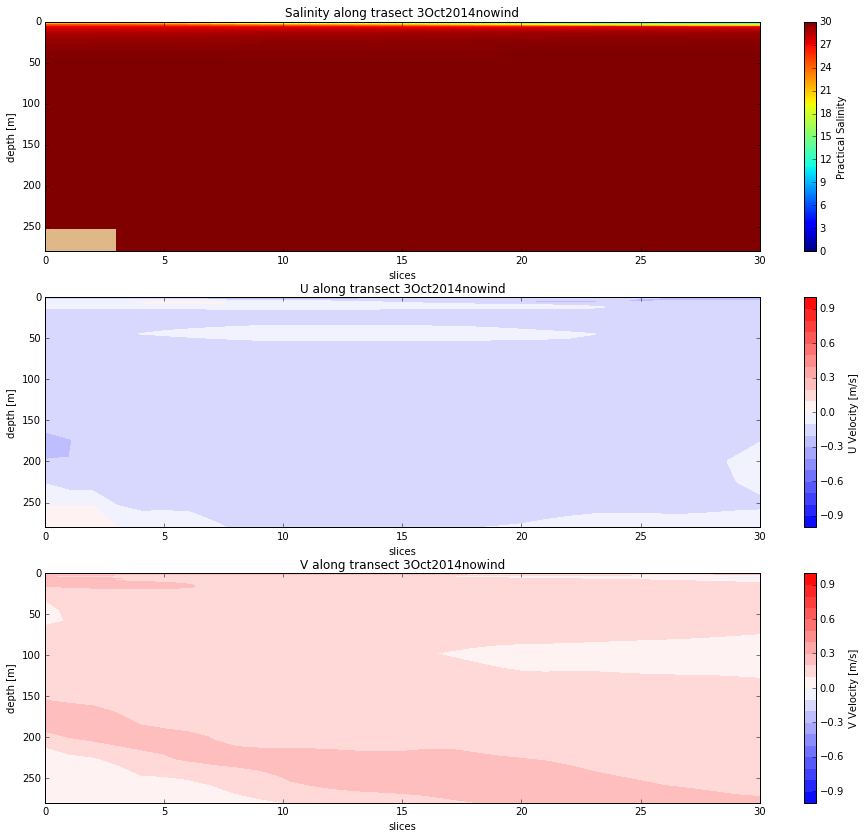

In [24]:
uvs_contour(U,V,S,depU,depV,'Oct2014nowind','3',33,st = 'middle of flood')

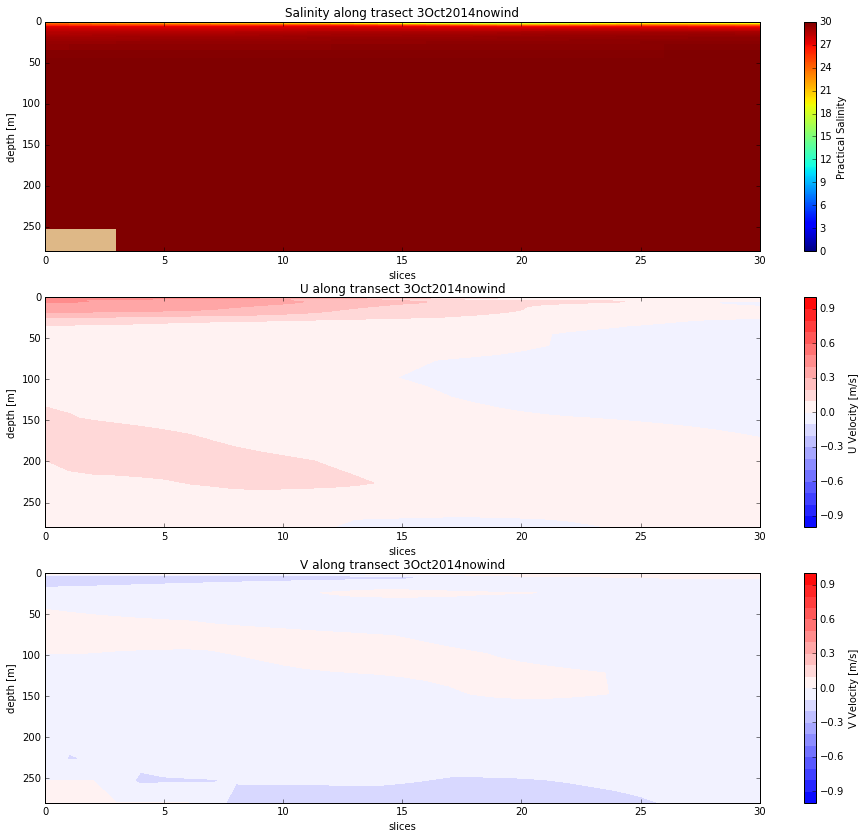

In [25]:
uvs_contour(U,V,S,depU,depV,'Oct2014nowind','3',33,st = 't_ind_high')

* transect 4

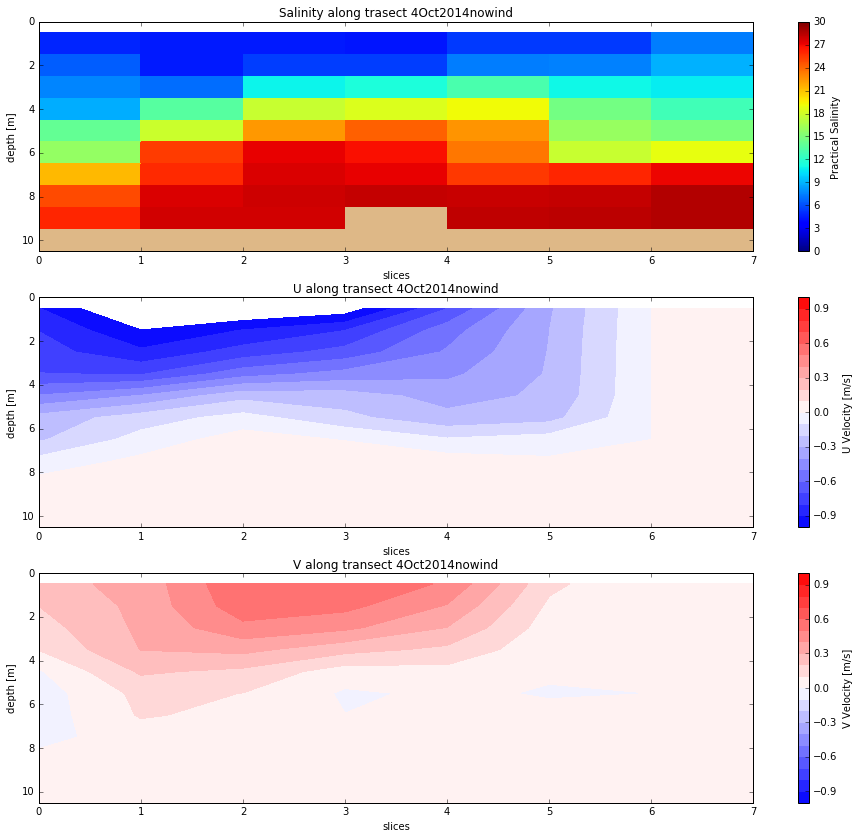

In [26]:
uvs_contour(U,V,S,depU,depV,'Oct2014nowind','4',10,st = 't_ind_low')

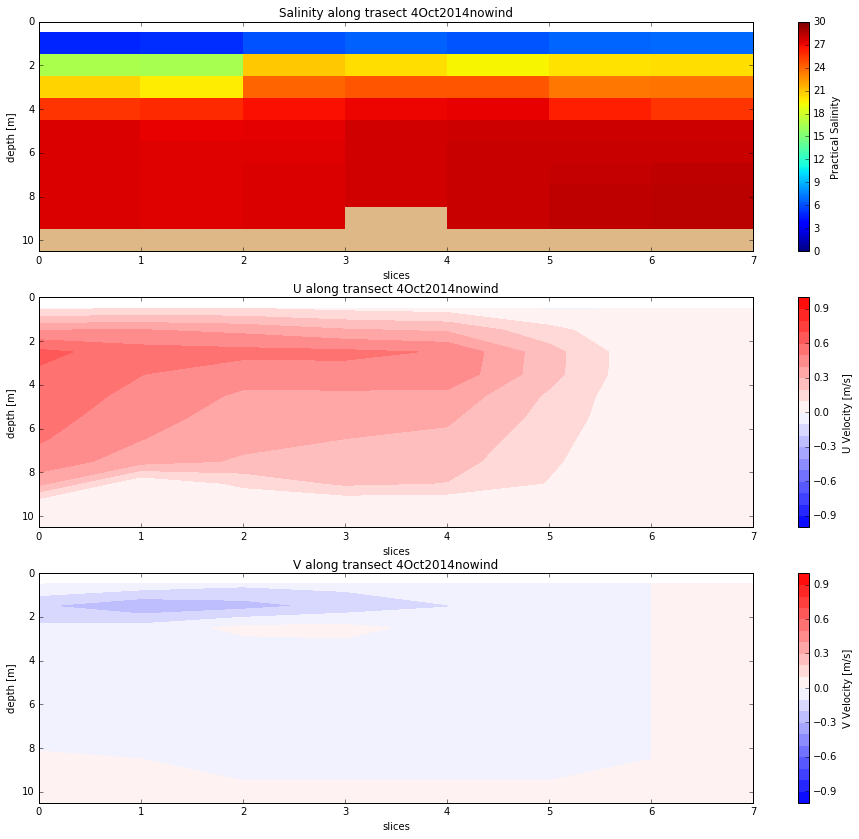

In [27]:
uvs_contour(U,V,S,depU,depV,'Oct2014nowind','4',10,st = 'middle of flood')

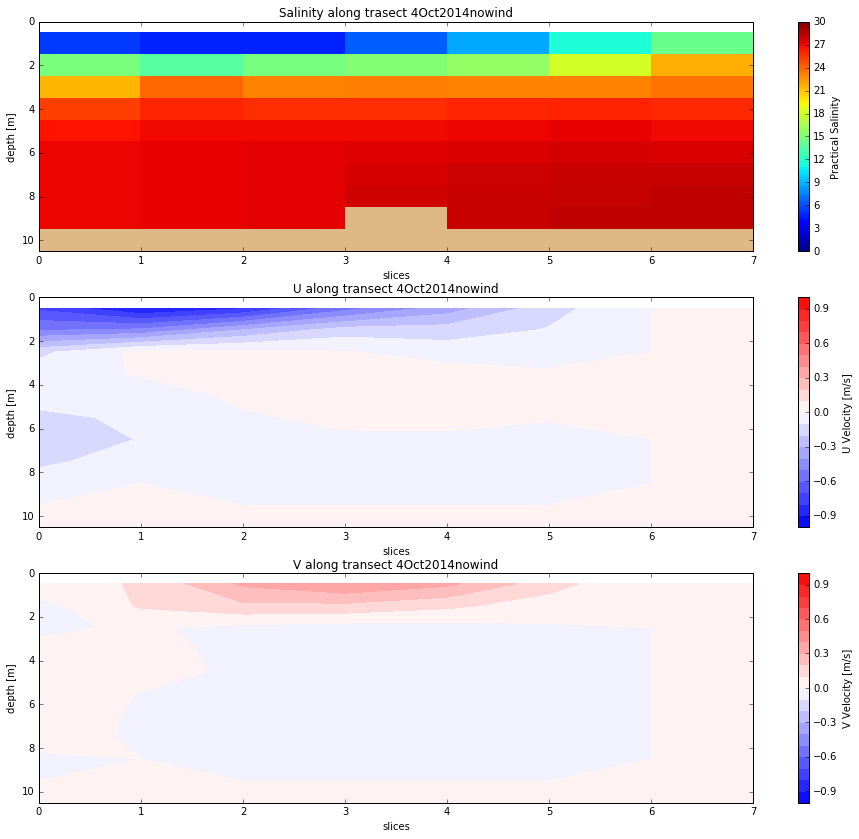

In [28]:
uvs_contour(U,V,S,depU,depV,'Oct2014nowind','4',10,st = 't_ind_high')

# Nof

* transect 1

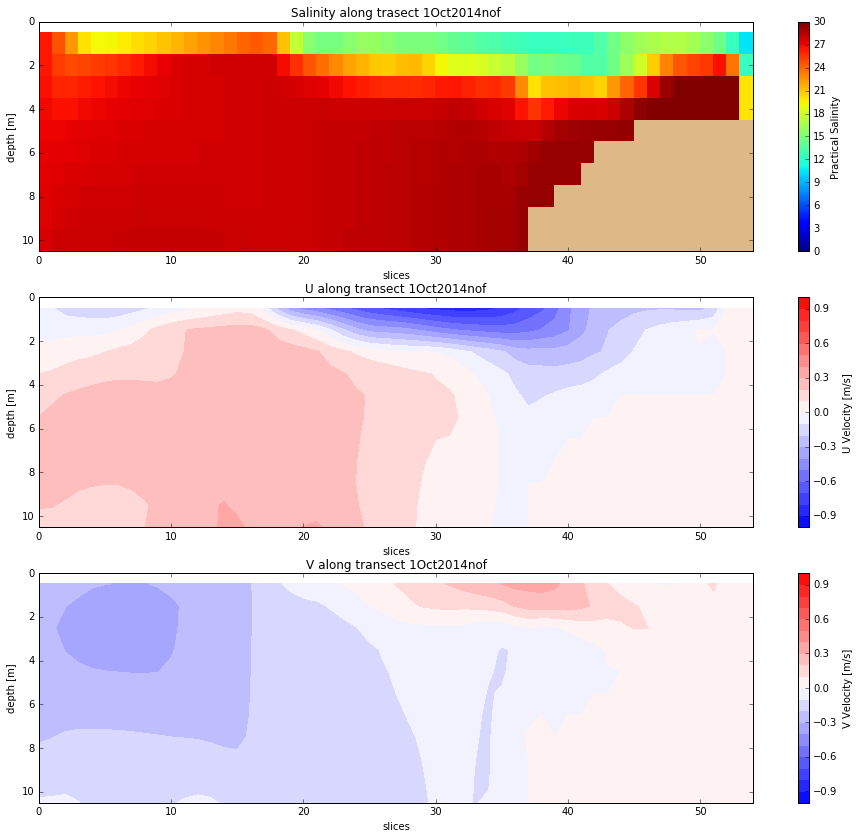

In [29]:
uvs_contour(U,V,S,depU,depV,'Oct2014nof','1',10,st = 't_ind_low')

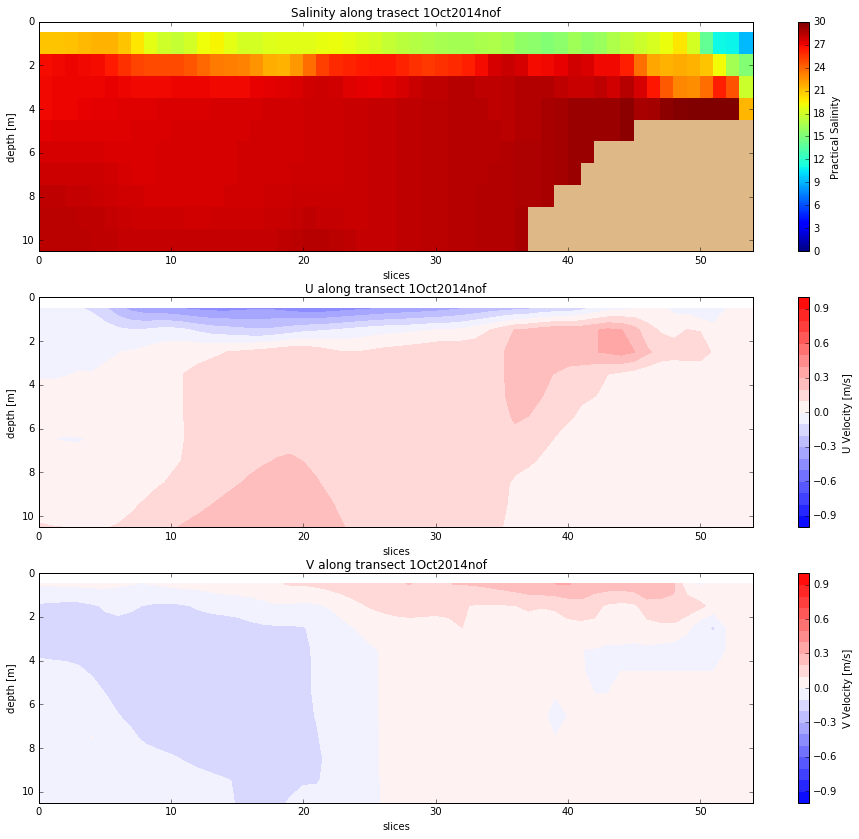

In [30]:
uvs_contour(U,V,S,depU,depV,'Oct2014nof','1',10,st = 'middle of flood')

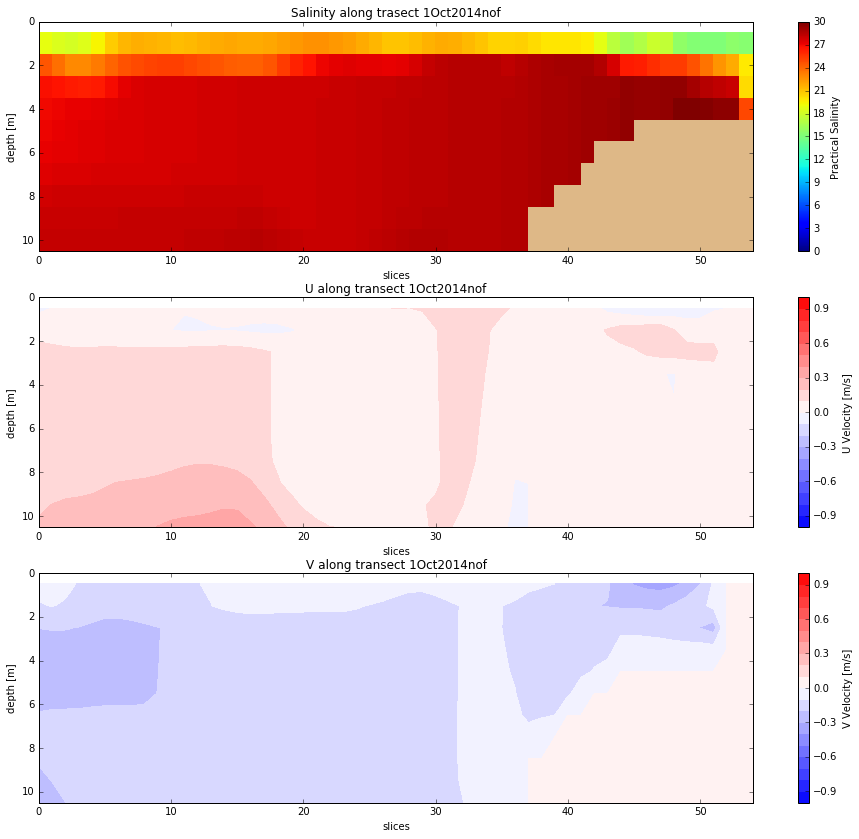

In [31]:
uvs_contour(U,V,S,depU,depV,'Oct2014nof','1',10,st = 't_ind_high')

* transect 2

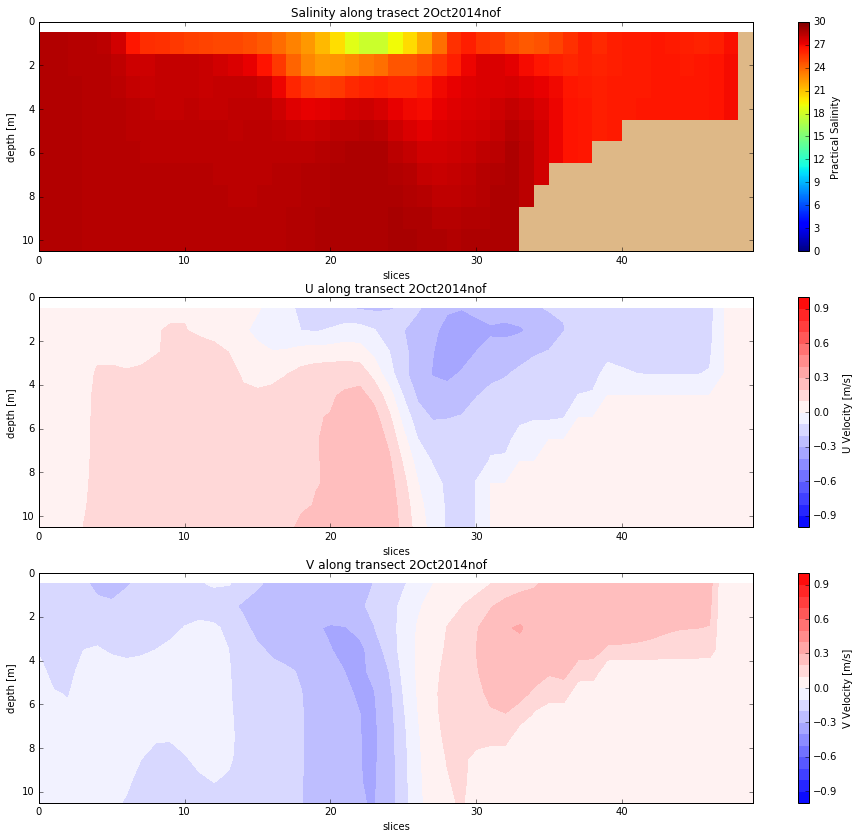

In [32]:
uvs_contour(U,V,S,depU,depV,'Oct2014nof','2',10,st = 't_ind_low')

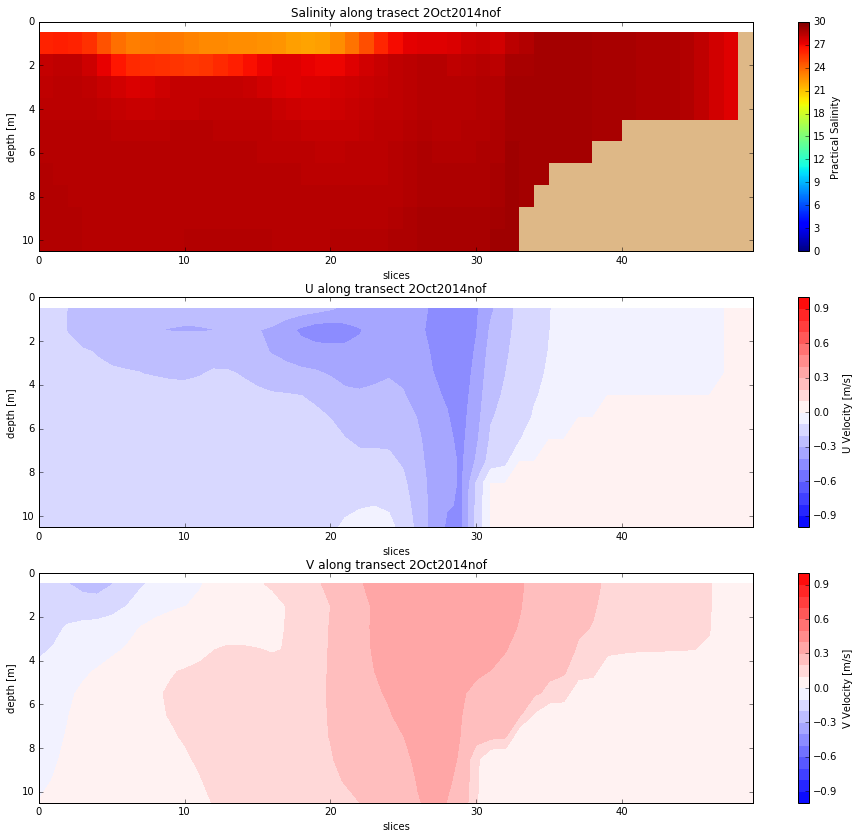

In [33]:
uvs_contour(U,V,S,depU,depV,'Oct2014nof','2',10,st = 'middle of flood')

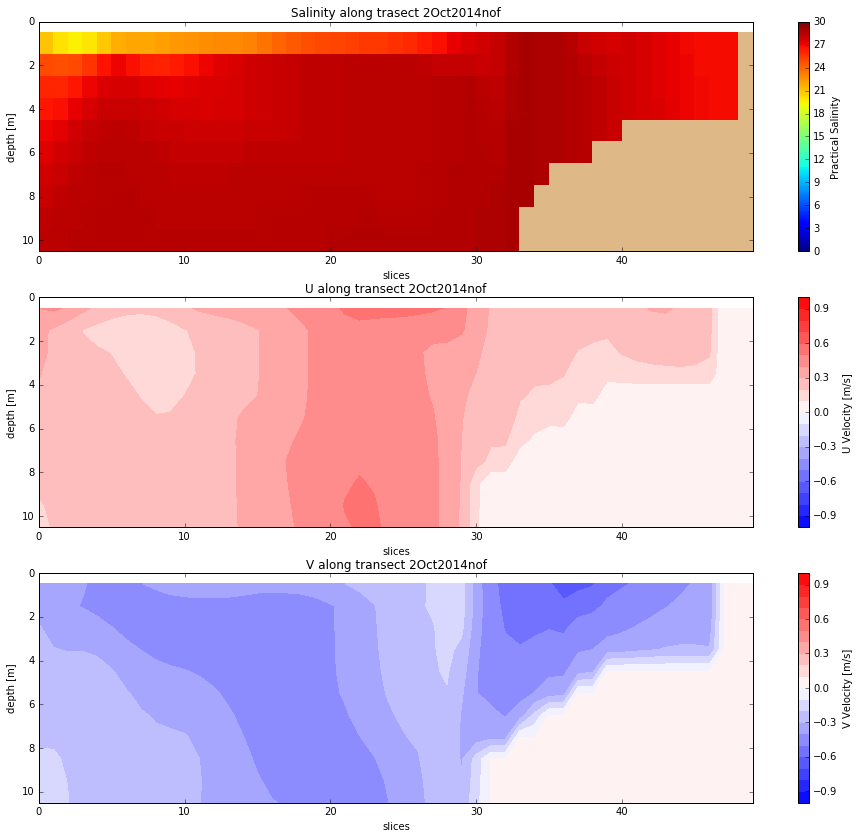

In [34]:
uvs_contour(U,V,S,depU,depV,'Oct2014nof','2',10,st = 't_ind_high')

* transect 3

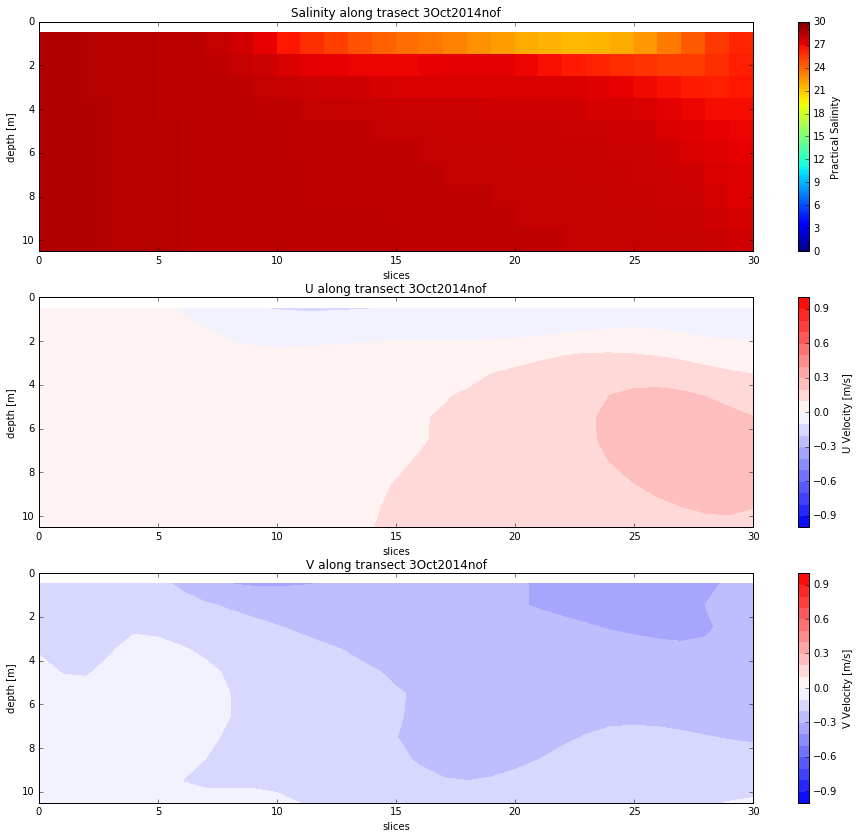

In [35]:
uvs_contour(U,V,S,depU,depV,'Oct2014nof','3',10,st = 't_ind_low')

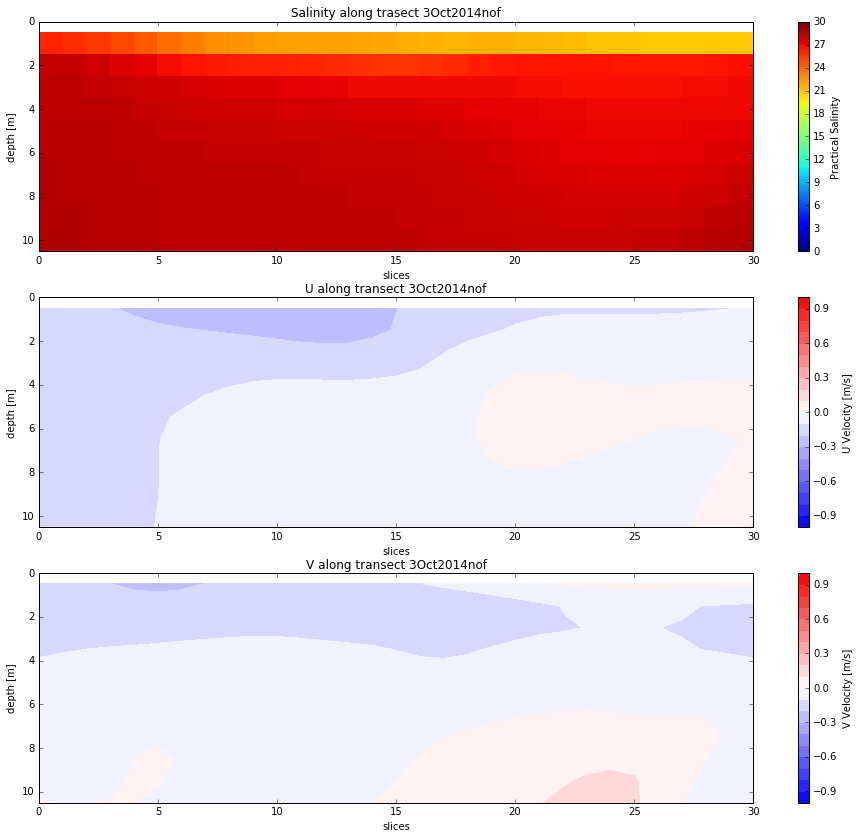

In [36]:
uvs_contour(U,V,S,depU,depV,'Oct2014nof','3',10,st = 'middle of flood')

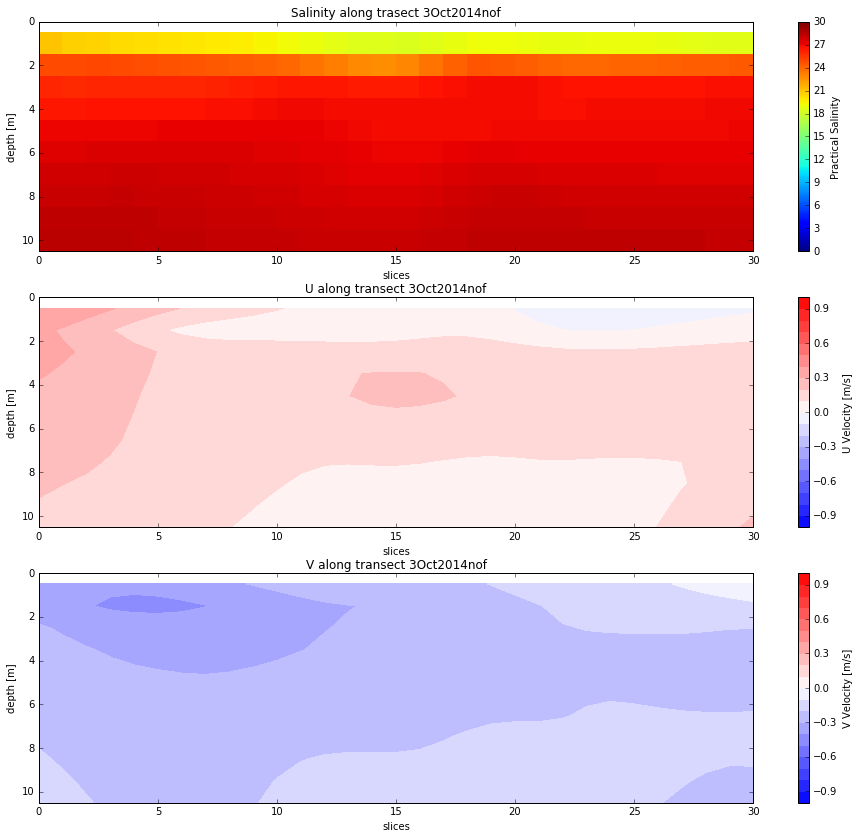

In [37]:
uvs_contour(U,V,S,depU,depV,'Oct2014nof','3',10,st = 't_ind_high')

* transect 4

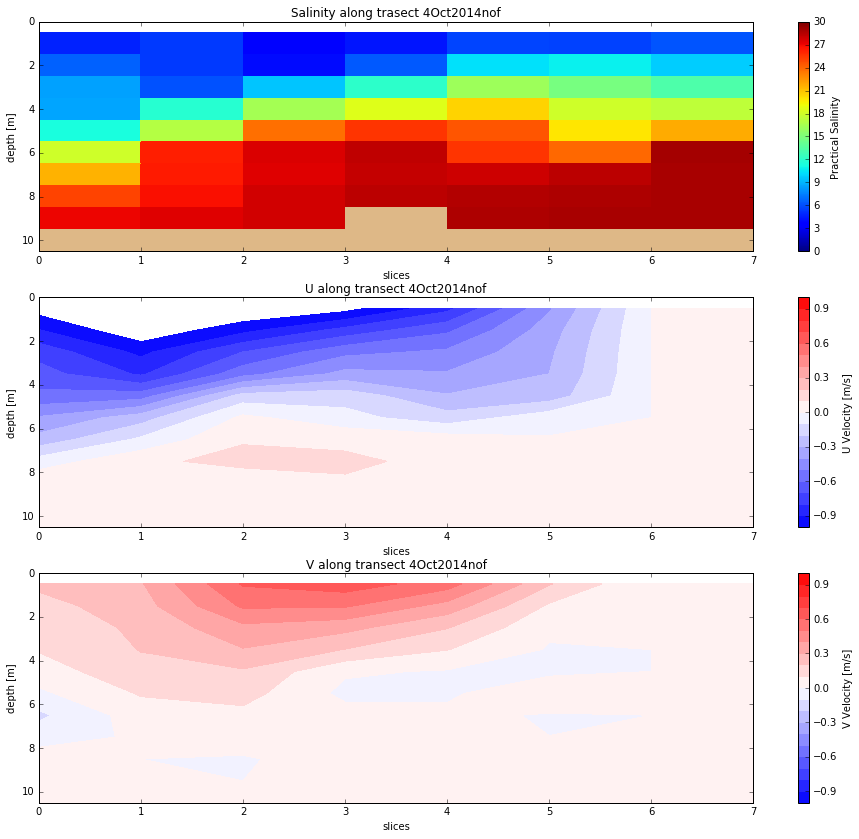

In [38]:
uvs_contour(U,V,S,depU,depV,'Oct2014nof','4',10,st = 't_ind_low')

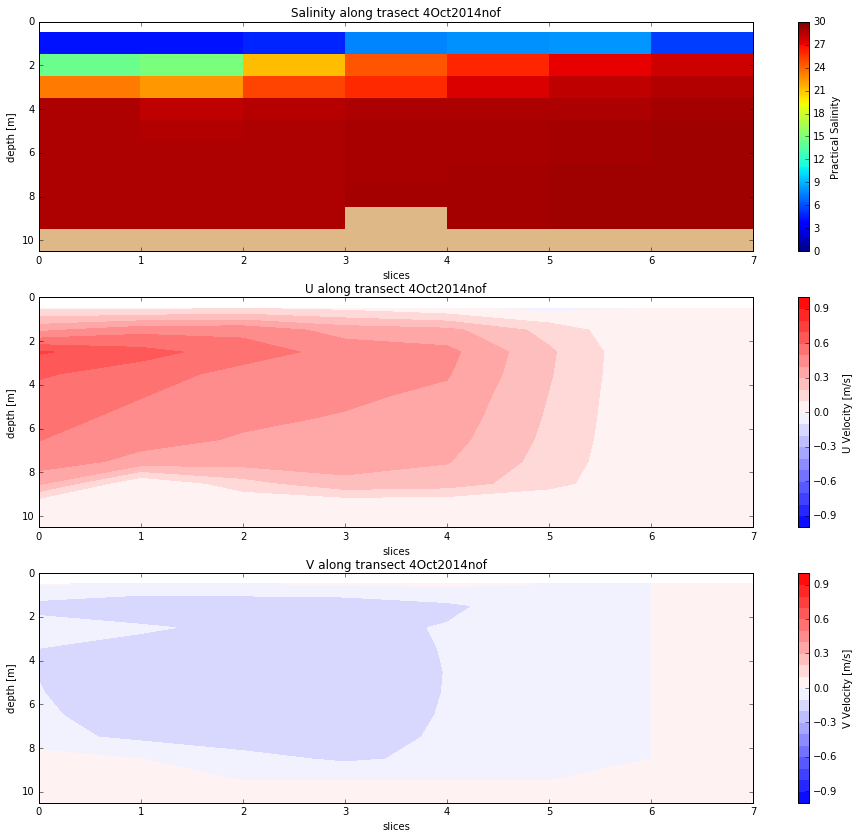

In [39]:
uvs_contour(U,V,S,depU,depV,'Oct2014nof','4',10,st = 'middle of flood')

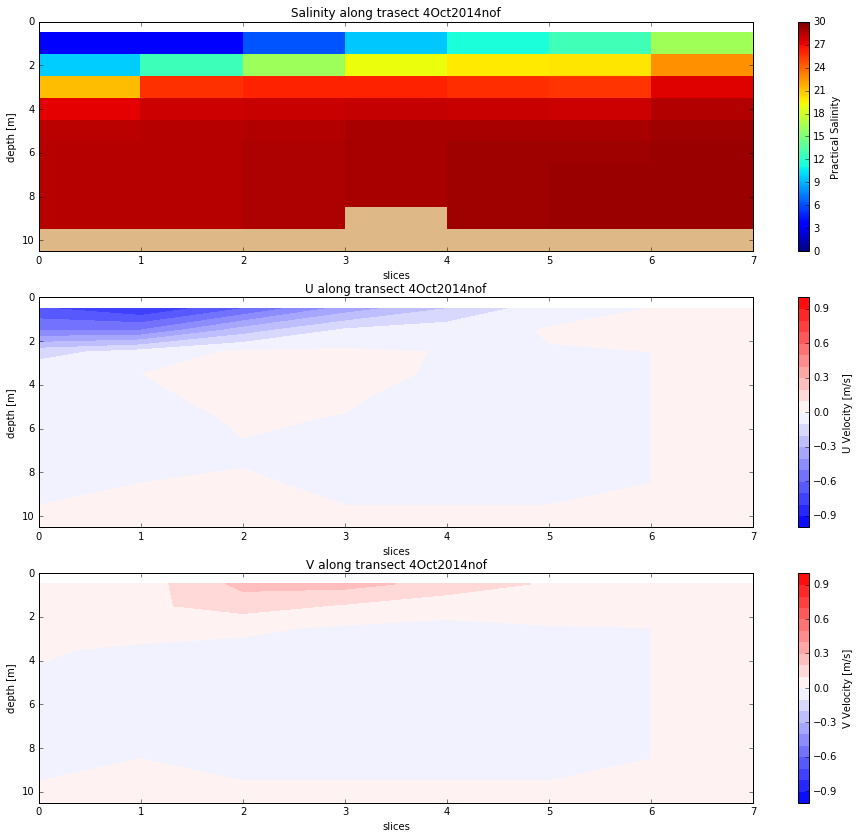

In [40]:
uvs_contour(U,V,S,depU,depV,'Oct2014nof','4',10,st = 't_ind_high')

# Combineall

* transect 1

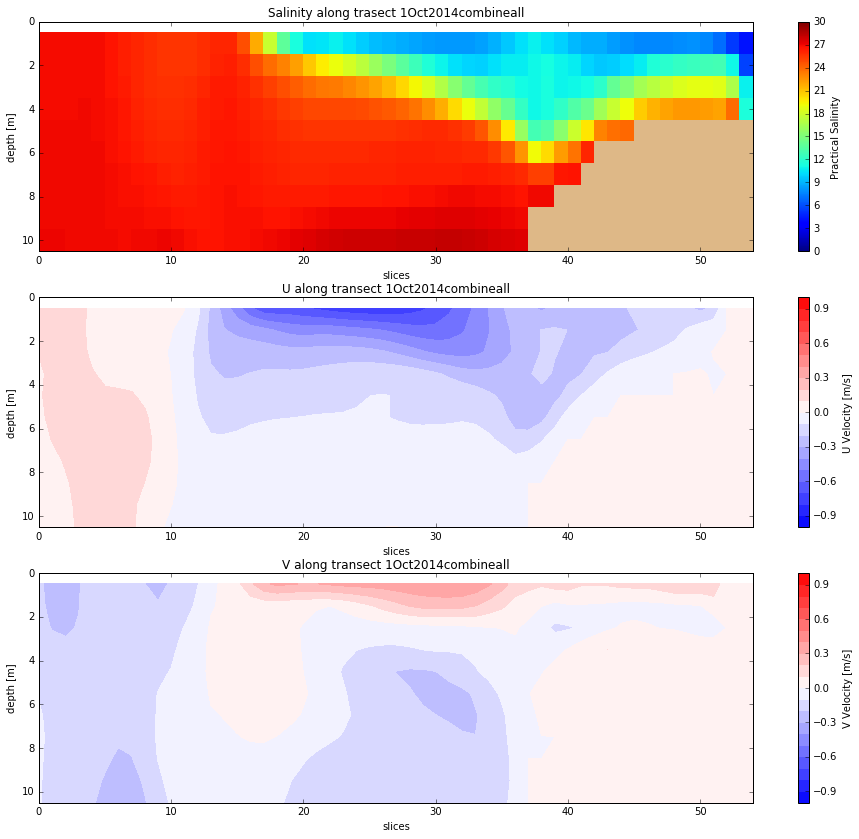

In [41]:
uvs_contour(U,V,S,depU,depV,'Oct2014combineall','1',10,st = 't_ind_low')

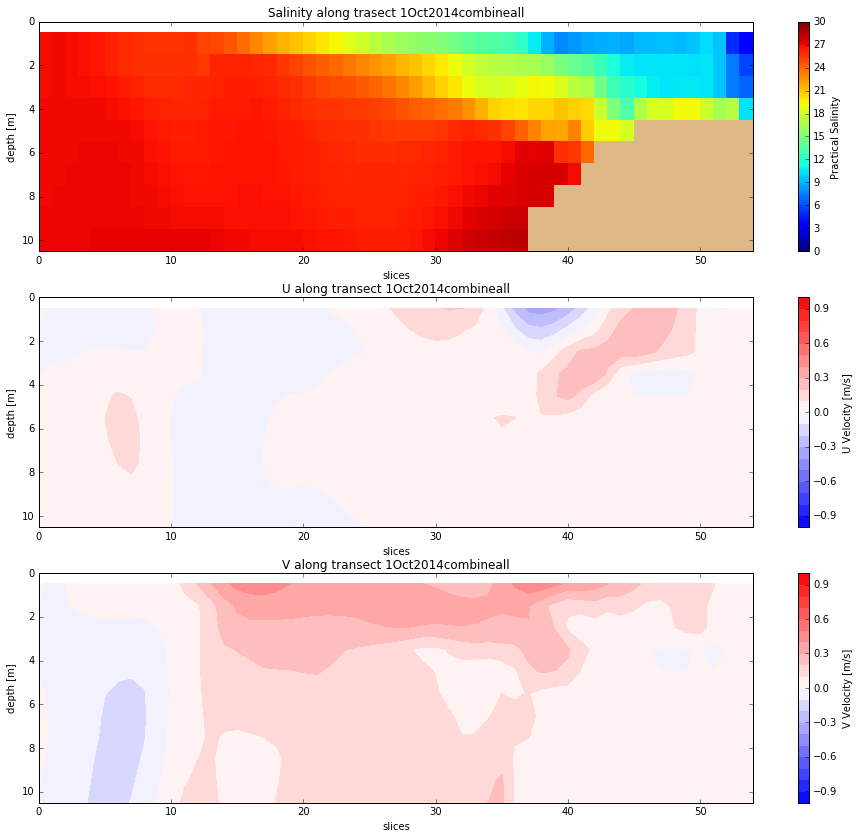

In [42]:
uvs_contour(U,V,S,depU,depV,'Oct2014combineall','1',10,st = 'middle of flood')

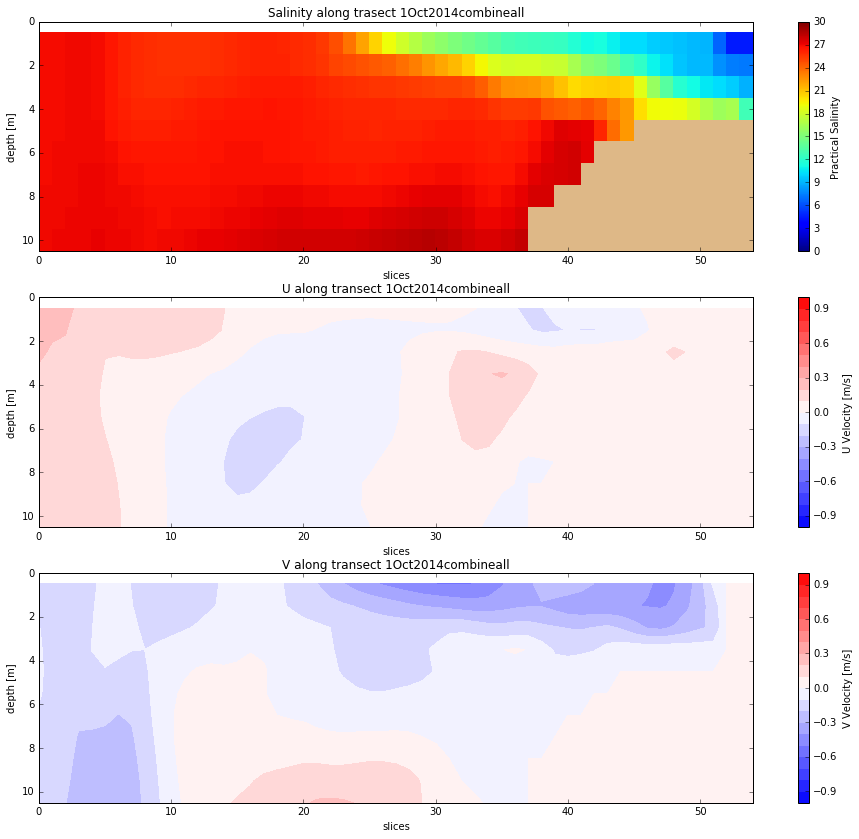

In [43]:
uvs_contour(U,V,S,depU,depV,'Oct2014combineall','1',10,st = 't_ind_high')

* transect 2

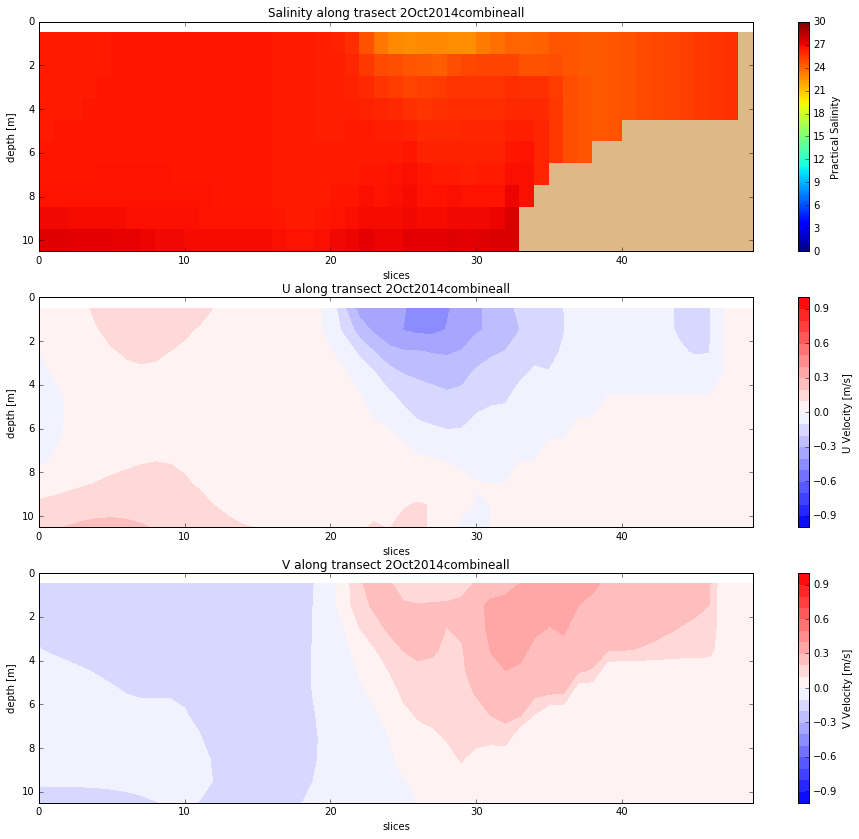

In [44]:
uvs_contour(U,V,S,depU,depV,'Oct2014combineall','2',10,st = 't_ind_low')

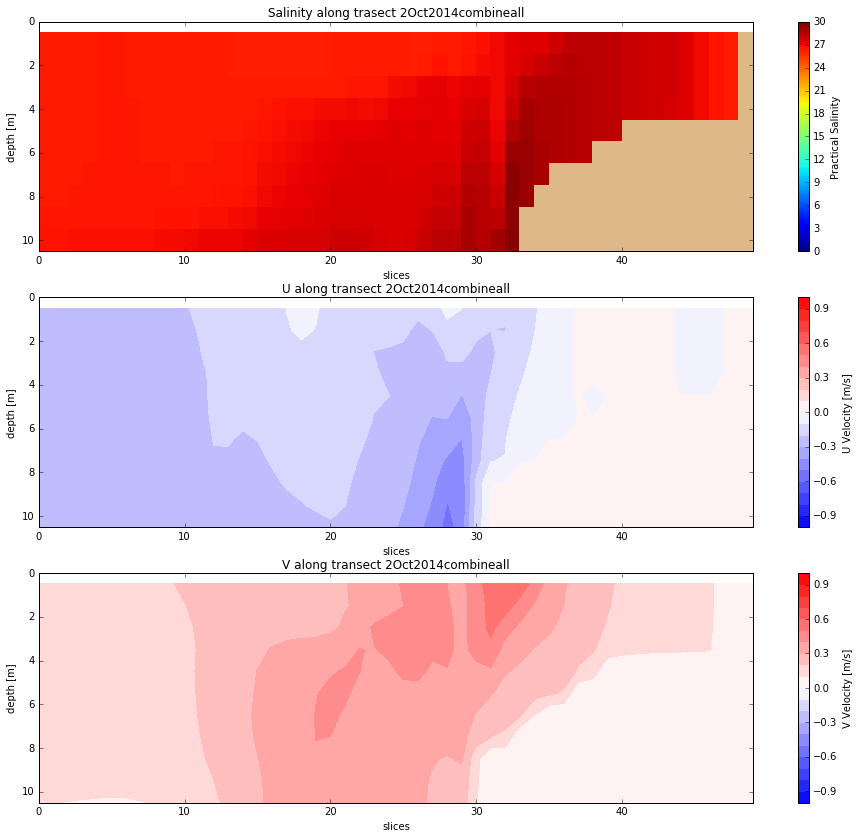

In [45]:
uvs_contour(U,V,S,depU,depV,'Oct2014combineall','2',10,st = 'middle of flood')

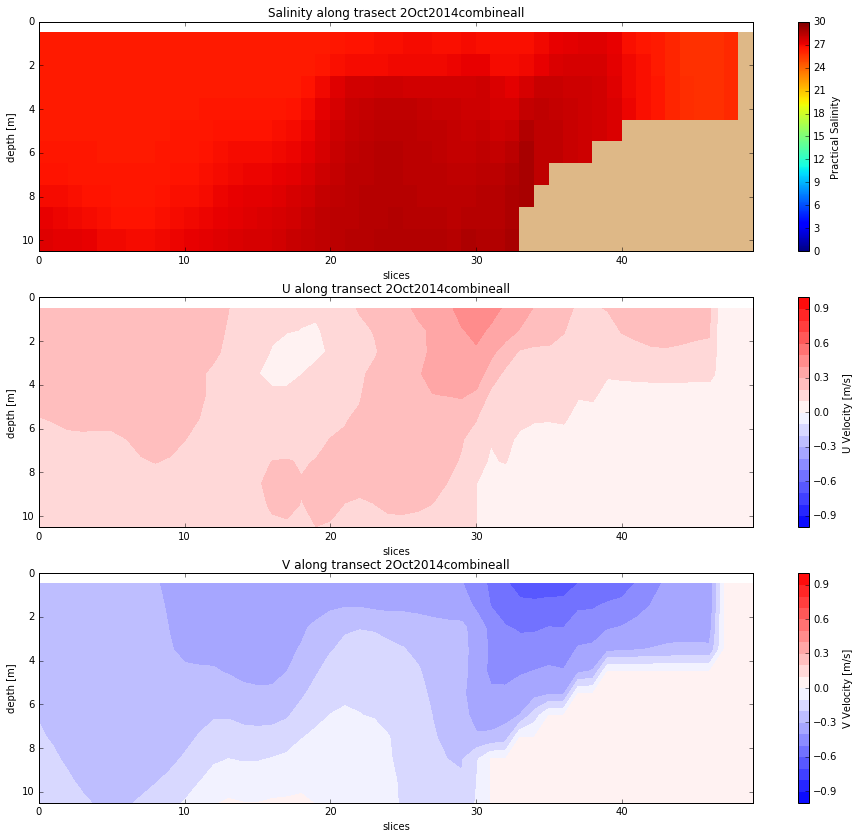

In [46]:
uvs_contour(U,V,S,depU,depV,'Oct2014combineall','2',10,st = 't_ind_high')

* transect 3

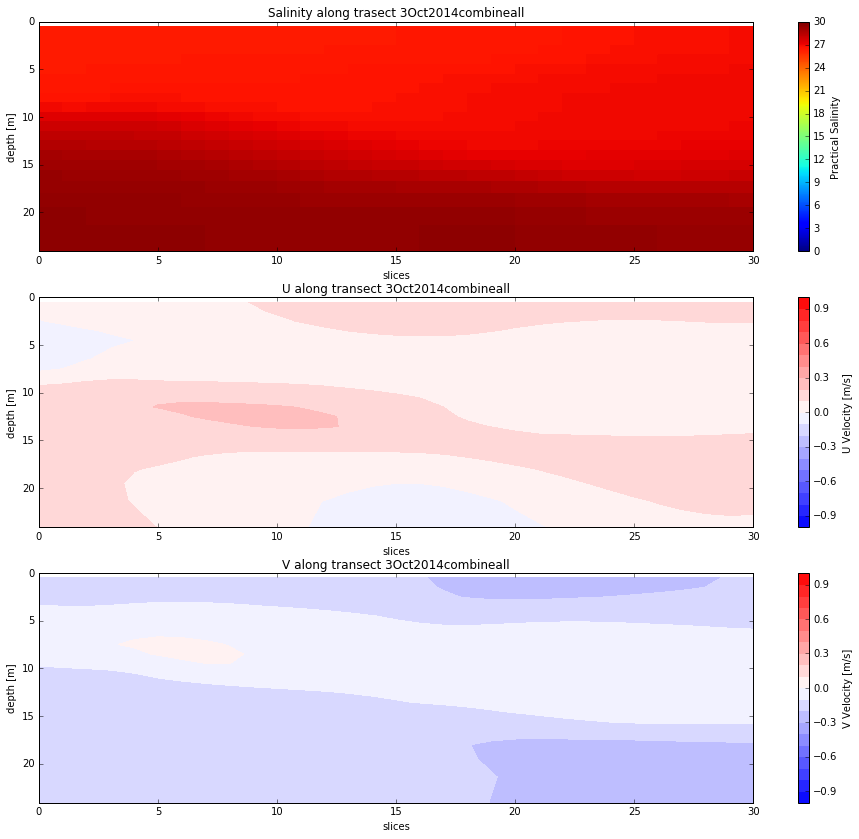

In [47]:
uvs_contour(U,V,S,depU,depV,'Oct2014combineall','3',20,st = 't_ind_low')

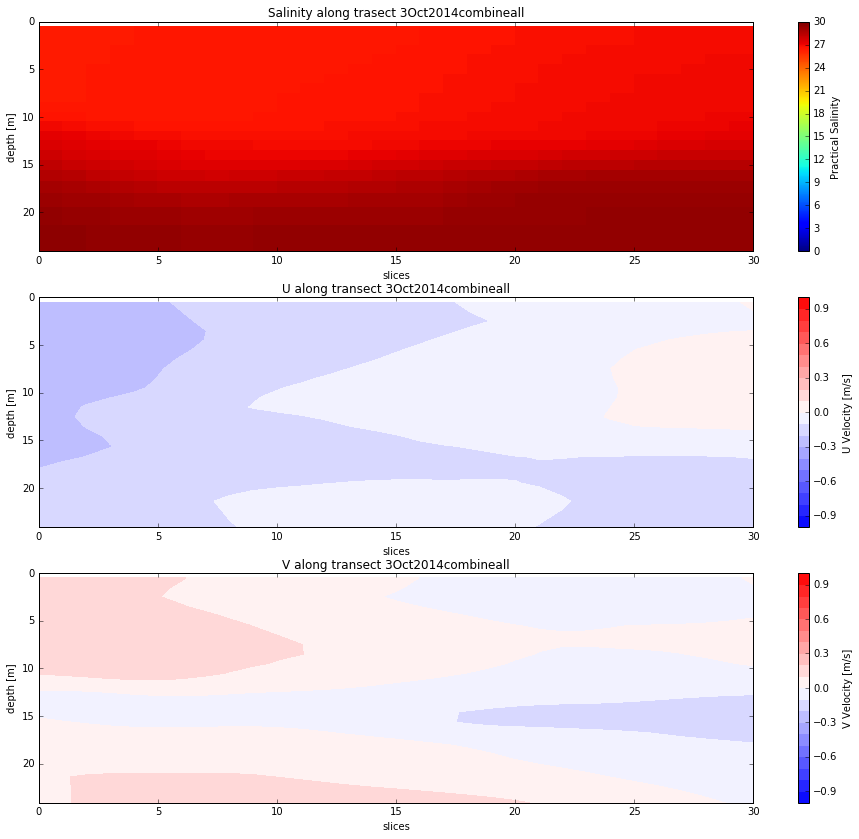

In [48]:
uvs_contour(U,V,S,depU,depV,'Oct2014combineall','3',20,st = 'middle of flood')

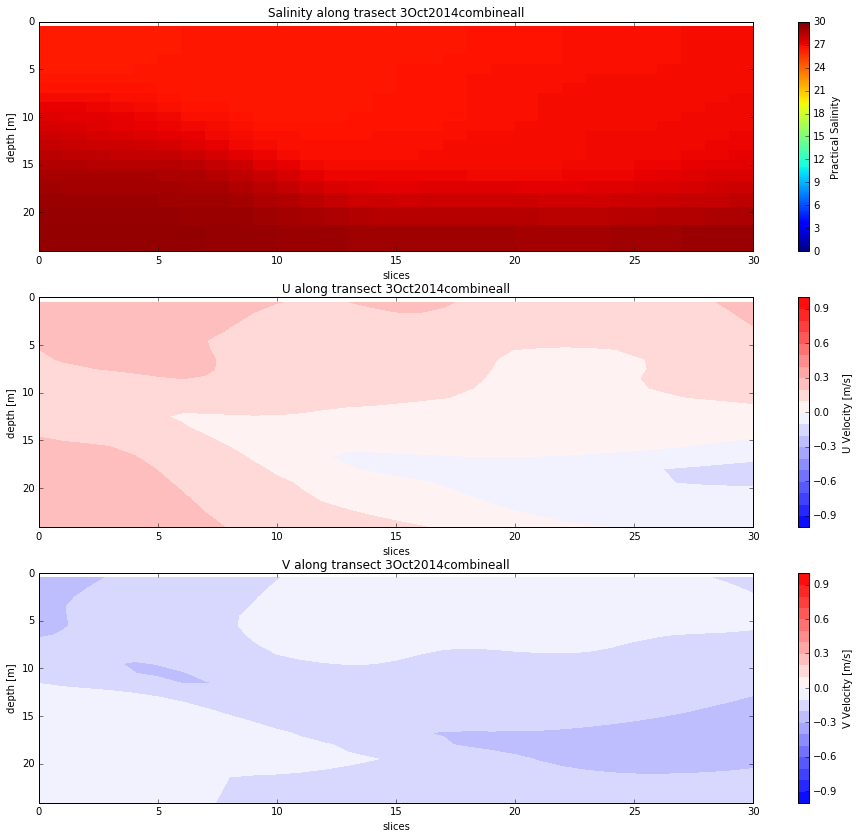

In [49]:
uvs_contour(U,V,S,depU,depV,'Oct2014combineall','3',20,st = 't_ind_high')

* transect 4

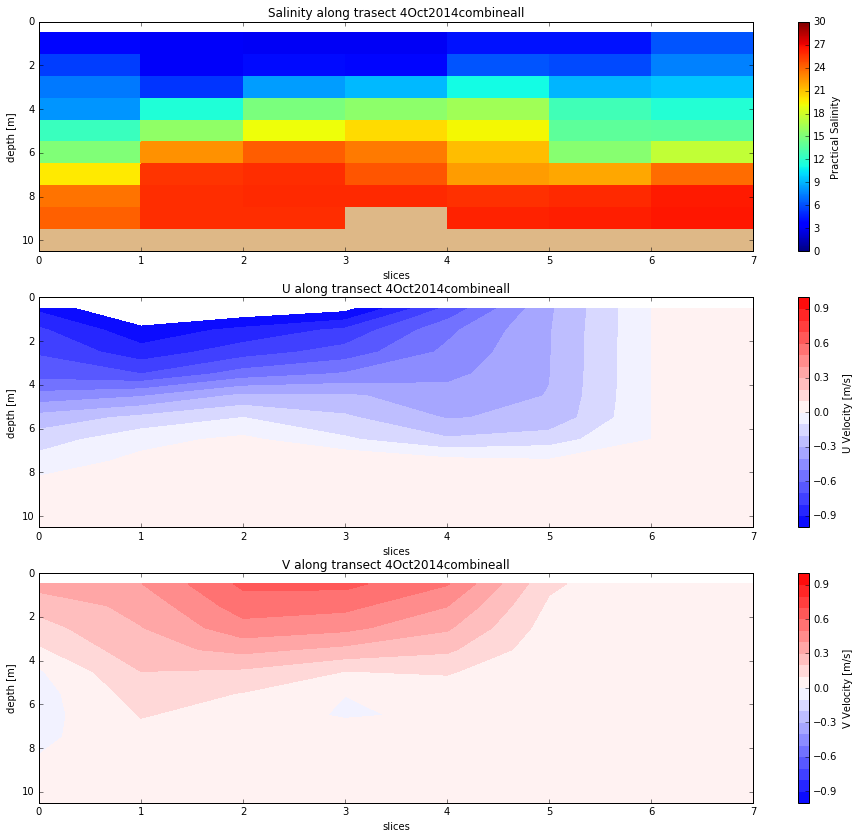

In [50]:
uvs_contour(U,V,S,depU,depV,'Oct2014combineall','4',10,st = 't_ind_low')

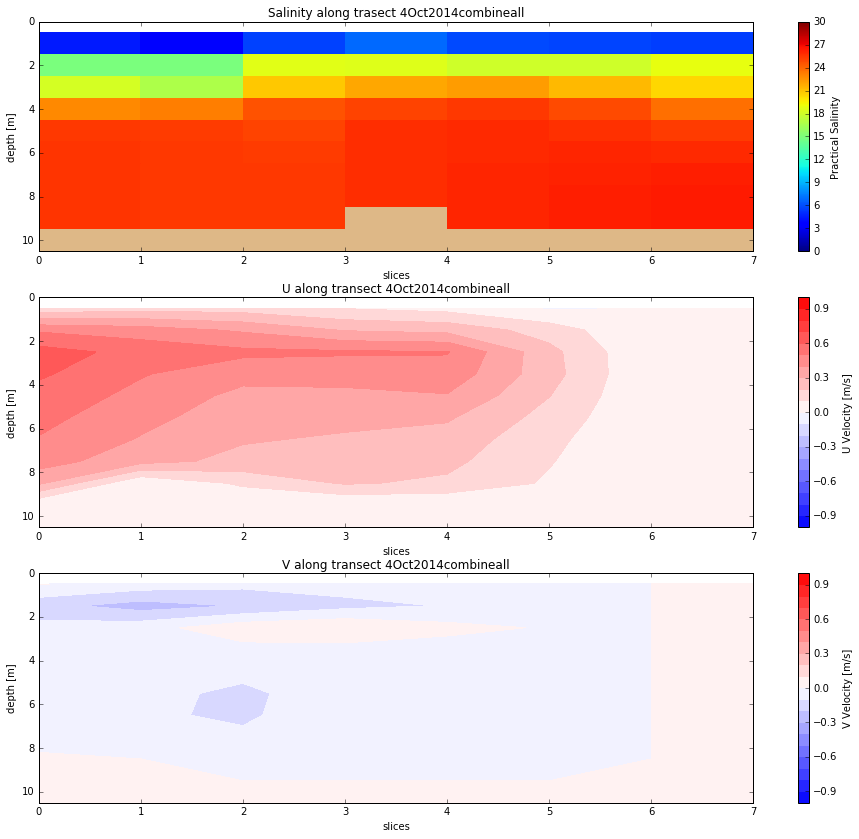

In [51]:
uu = uvs_contour(U,V,S,depU,depV,'Oct2014combineall','4',10,st = 'middle of flood')

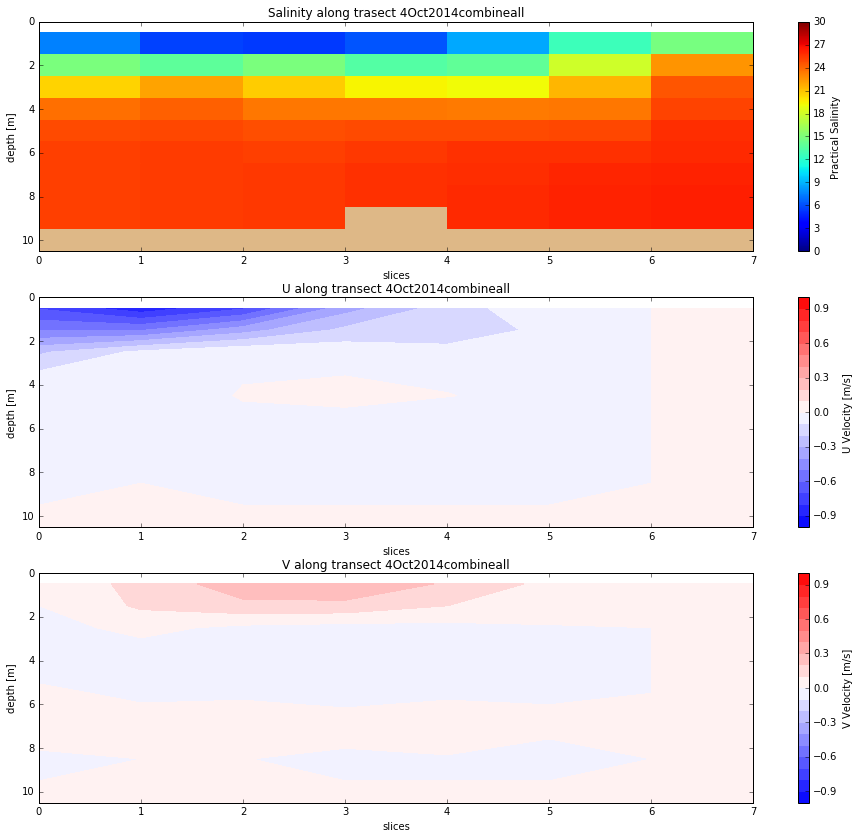

In [52]:
uvs_contour(U,V,S,depU,depV,'Oct2014combineall','4',10,st = 't_ind_high')

# Total transport

Oct2014OnlyRiver [25092.760748620174, 24912.201092041149, 24642.649209785101]
Oct2014notides [38577.33808818242, 38990.682204016965, 30471.843763741999]
Oct2014nowind [-47960.774247305992, 659757.23380825703, 73055.226708332775]
Oct2014nof [-110006.09452037296, 546055.10422745405, -177108.96064467533]
Oct2014combineall [-52926.386975447065, 655642.88377995812, 67906.255788191032]


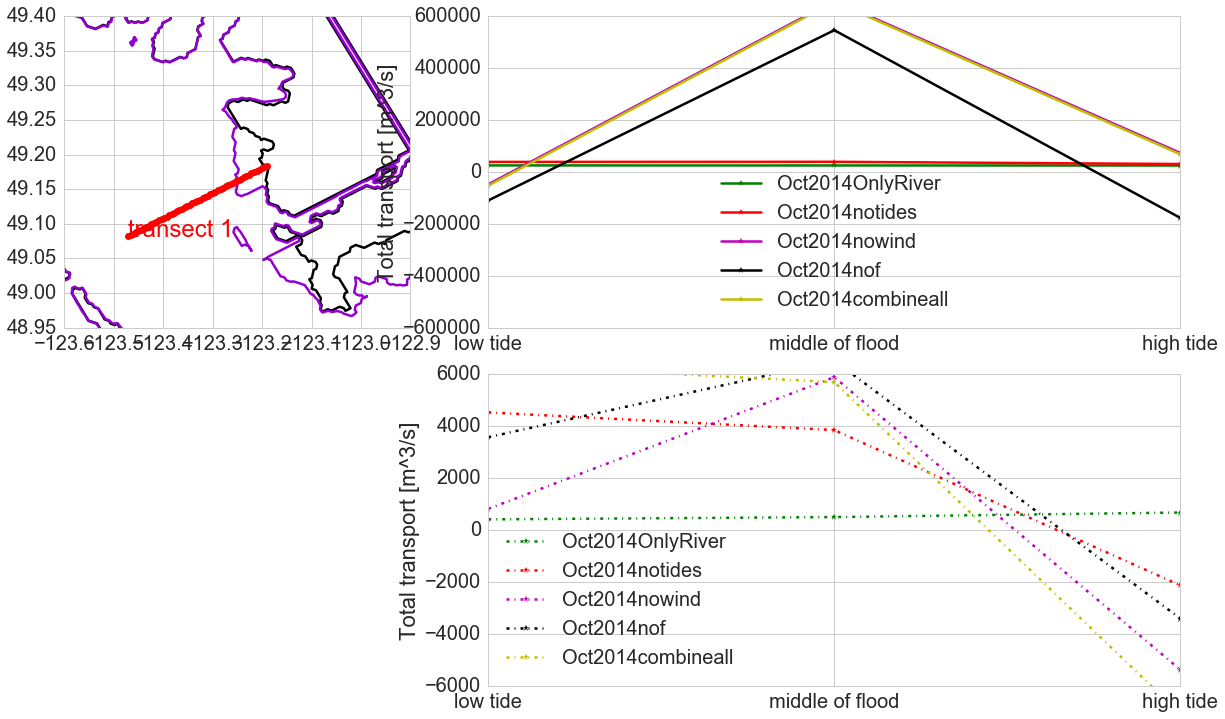

In [14]:
fig = transport_calculate(S,U,V,ssh,lon,lat,depU,depV,'1')

Oct2014OnlyRiver [8424.0249876912058, 8074.0732555745708, 7748.6903849337541]
Oct2014notides [38184.605384684226, 45357.046274748034, 38336.87942112091]
Oct2014nowind [-89621.115488128882, 881618.76635226328, -8244.2619891469076]
Oct2014nof [-104227.81674182968, 838456.18527290935, -184049.52344889403]
Oct2014combineall [-79911.149906977342, 910584.51355774188, 22410.300820646866]


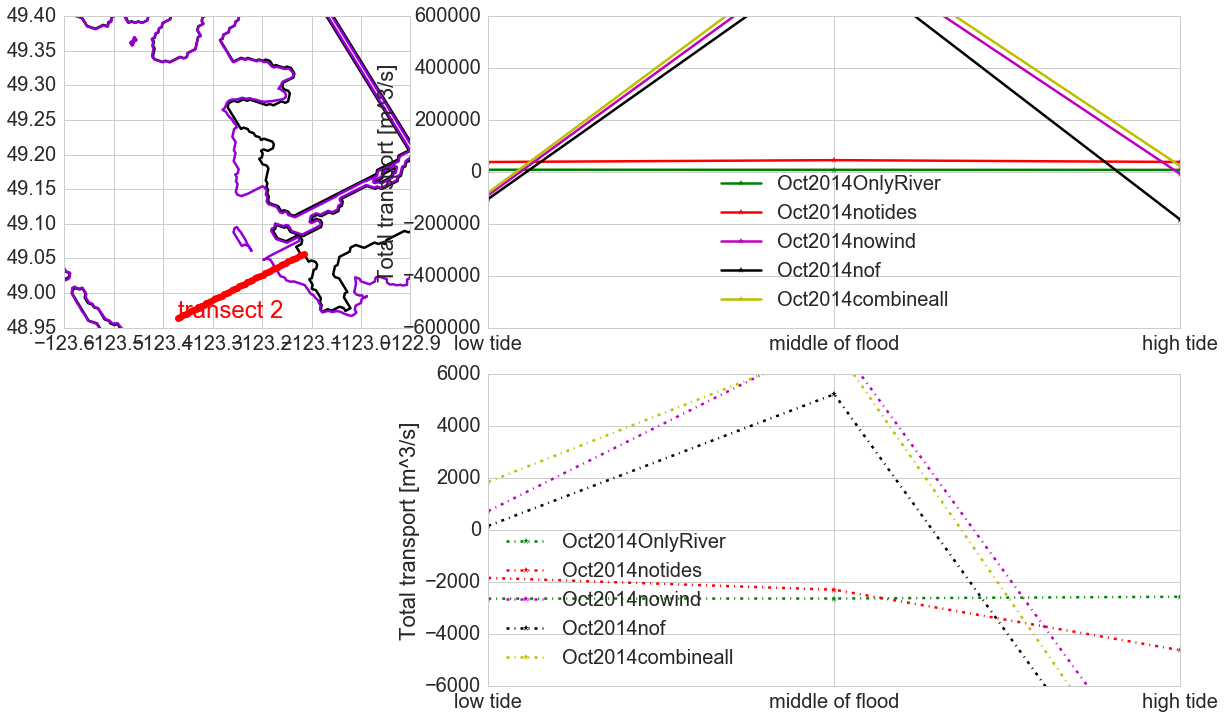

In [15]:
fig = transport_calculate(S,U,V,ssh,lon,lat,depU,depV,'2')

Oct2014OnlyRiver [13340.710791492336, 13598.09171559994, 13672.912968252493]
Oct2014notides [-3737.3819043748263, -10956.191652738607, -14270.242861313534]
Oct2014nowind [38890.101984788387, -168802.2730554819, 62051.737391784947]
Oct2014nof [-12538.41791952339, -231150.43458452911, -5754.1846325796541]
Oct2014combineall [23012.950323811823, -201109.73111638863, 29399.012348113509]


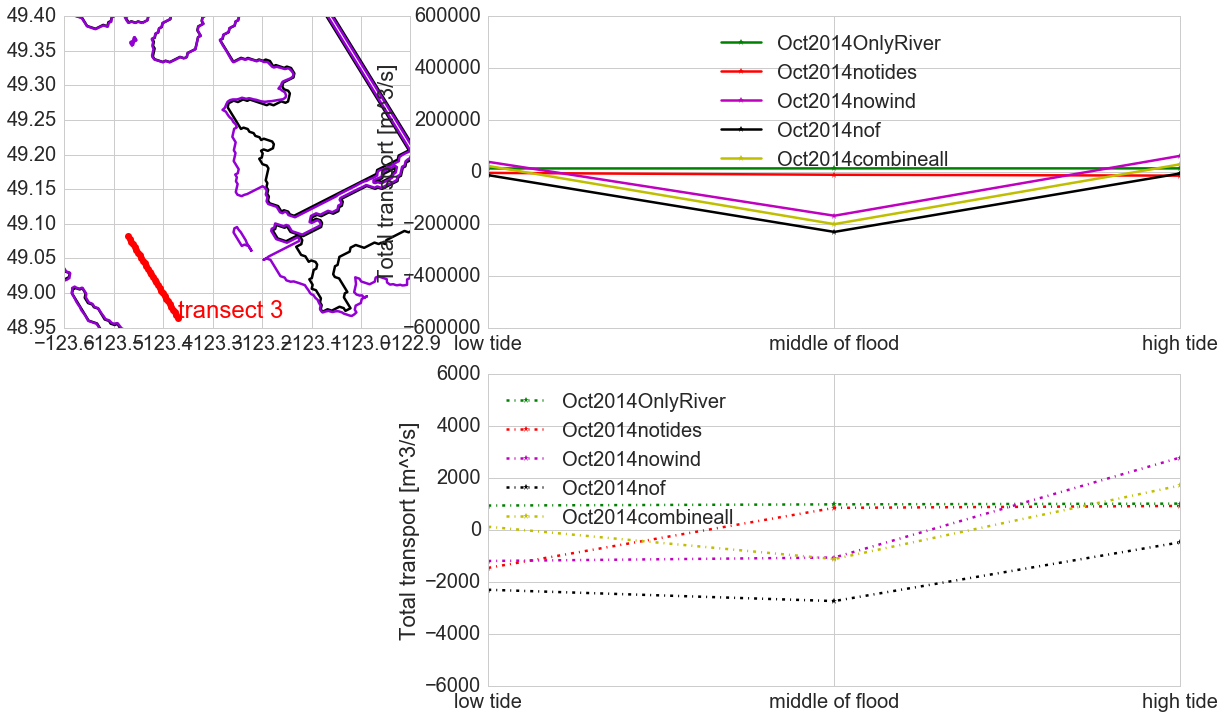

In [16]:
fig= transport_calculate(S,U,V,ssh,lon,lat,depU,depV,'3')

* No wind case does not affect much on the total water transport in the water column of the plume region, more important for downstream surface transport than upstream.
* Total transport at north/south transect of onlyriver/notide case is always upstream, with surface transport going north and south for each transect (north/south), respectively.

Oct2014OnlyRiver [-2024.3683592696427, -1996.1954824946483, -2017.3353428456139]
Oct2014notides [-2065.1249678798422, -2014.5169084666929, -1949.4097678750977]
Oct2014nowind [-4733.2855285709084, 5869.9665006906071, -2375.8984583037568]
Oct2014nof [-4854.4165051364953, 6039.5114898731899, -2045.5027313267033]
Oct2014combineall [-4722.6184395073342, 5959.199383943298, -2520.0430629155371]


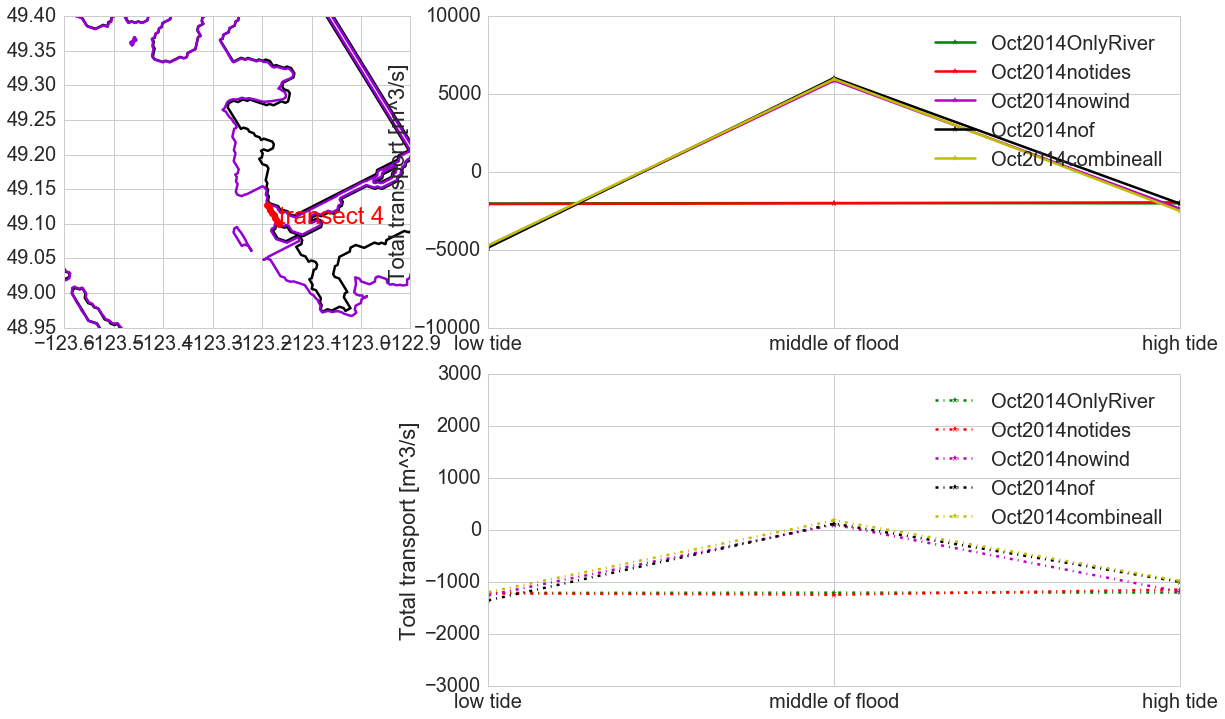

In [17]:
fig = transport_calculate(S,U,V,ssh,lon,lat,depU,depV,'4',y0lim=1e4,y1lim=3e3)

# fresh water transport

Oct2014OnlyRiver [-13680.434420308884, -13582.676049103306, -13494.125448129427]
Oct2014notides [-12795.42421792031, -13642.226290512464, -18545.440650828397]
Oct2014nowind [-214.9900152303978, 1831.5302946684733, -8412.7749971435805]
Oct2014nof [-1217.596141848107, -12395.72925892202, -5171.1979109197946]
Oct2014combineall [5057.0822292042758, -4631.9322084238584, -9245.524788303821]


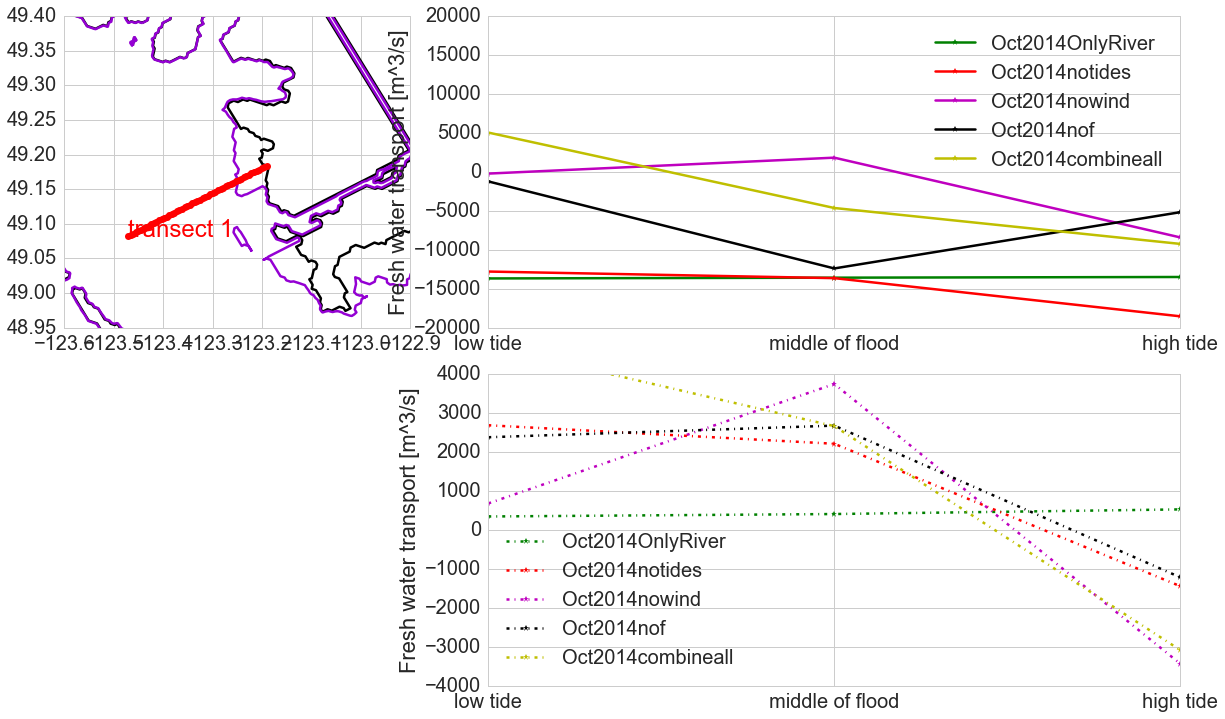

In [18]:
fig = transport_calculate(S,U,V,ssh,lon,lat,depU,depV,'1',fresh_flag = True, y0lim =2e4,y1lim = 4e3)

Oct2014OnlyRiver [-17187.706786033712, -17176.67339494207, -17076.582980880656]
Oct2014notides [-14921.462001591586, -15732.951109414622, -16555.124143414385]
Oct2014nowind [-1898.1355119599111, 2563.4012948473683, -10462.051529585504]
Oct2014nof [-1214.311609565018, -10642.4993664391, -12323.320674340272]
Oct2014combineall [768.40404343659941, -2122.3177606535064, -8579.6903411958119]


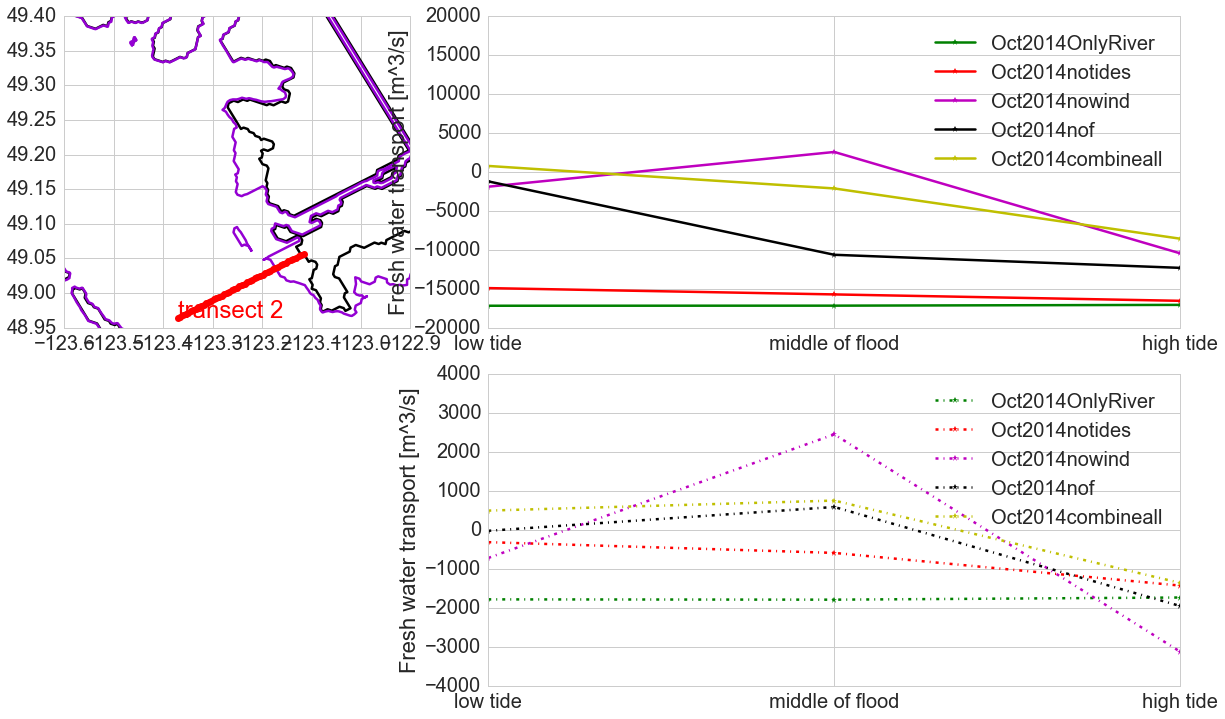

In [25]:
fig = transport_calculate(S,U,V,ssh,lon,lat,depU,depV,'2',fresh_flag = True,y0lim =2e4, y1lim = 4e3)

In [26]:
# get Fraser Flow data
filename = '/data/dlatorne/SOG-projects/SOG-forcing/ECget/Fraser_flow'
fraserflow = np.loadtxt(filename)
fraserflow[353:357]

array([[ 2014.   ,    10.   ,     6.   ,  1684.899],
       [ 2014.   ,    10.   ,     7.   ,  1796.79 ],
       [ 2014.   ,    10.   ,     8.   ,  1994.658],
       [ 2014.   ,    10.   ,     9.   ,  2068.11 ]])

Oct2014OnlyRiver [-17187.706786033712, -17176.67339494207, -17076.582980880656]
Oct2014notides [-14921.462001591586, -15732.951109414622, -16555.124143414385]
Oct2014nowind [-1898.1355119599111, 2563.4012948473683, -10462.051529585504]
Oct2014nof [-1214.311609565018, -10642.4993664391, -12323.320674340272]
Oct2014combineall [768.40404343659941, -2122.3177606535064, -8579.6903411958119]


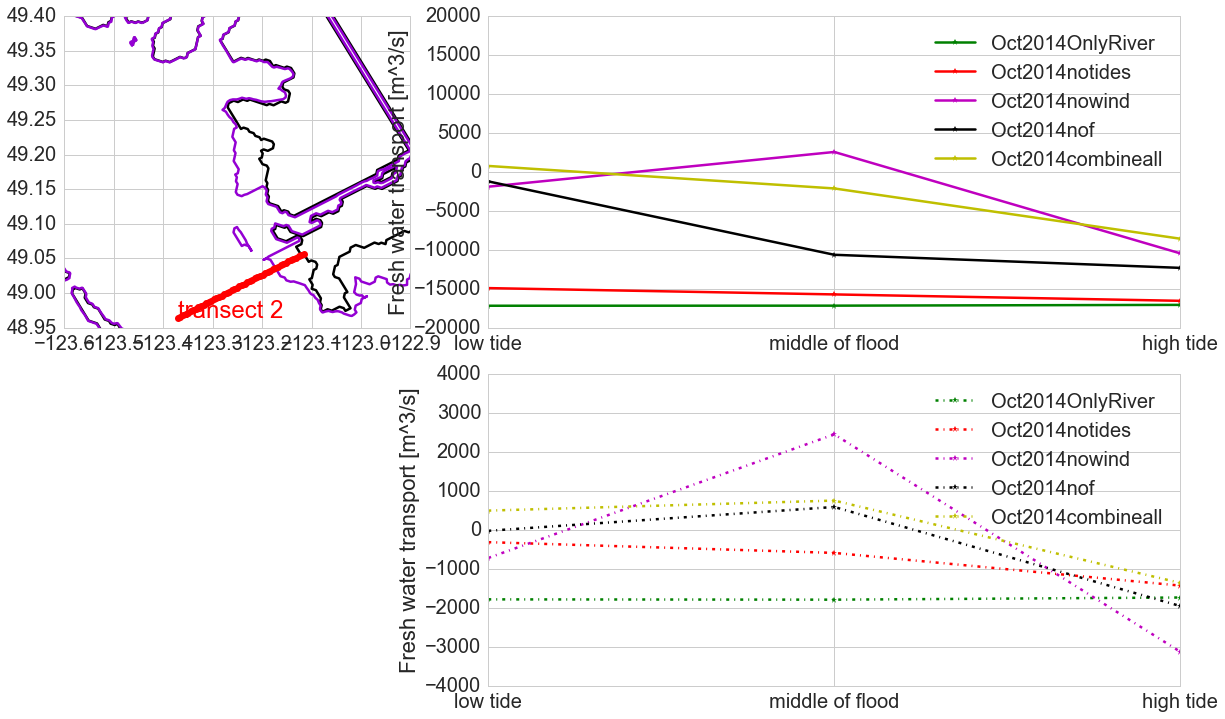

In [27]:
fig = transport_calculate(S,U,V,ssh,lon,lat,depU,depV,'2',fresh_flag = True,y0lim =2e4, y1lim = 4e3)

Oct2014OnlyRiver [859.66003606271124, 859.75823729324577, 860.9639389324991]
Oct2014notides [492.2508073732925, 1184.6122296973845, 796.49299860948804]
Oct2014nowind [-2273.4041258783254, 126.57329913137528, 5069.7522138933446]
Oct2014nof [156.98517345627693, 3065.1201215444435, -384.92953692422441]
Oct2014combineall [-318.23604960106729, 1124.2083347931182, 1536.256111545903]


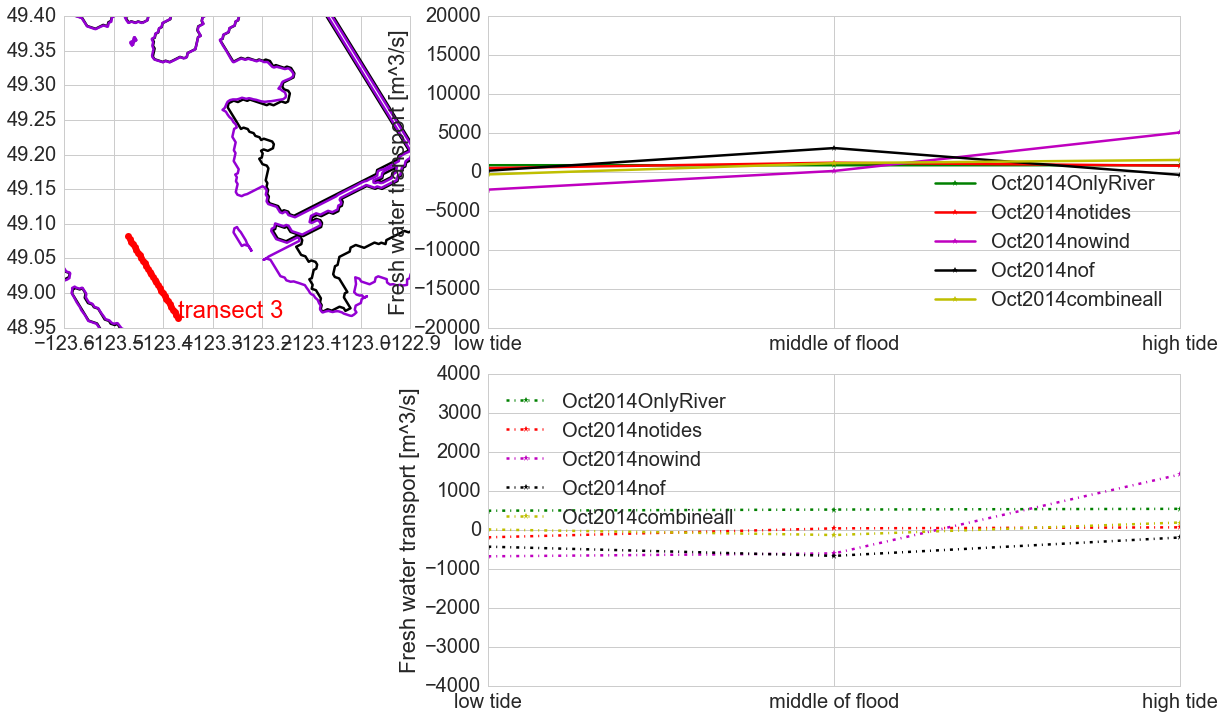

In [28]:
fig = transport_calculate(S,U,V,ssh,lon,lat,depU,depV,'3',fresh_flag = True,y0lim =2e4, y1lim = 4e3)

Oct2014OnlyRiver [-1939.6071537784535, -1943.5502354980756, -1925.4868670553494]
Oct2014notides [-1903.2083618242907, -1928.5199949882085, -1847.3260290109972]
Oct2014nowind [-3235.1435564444678, 900.29097887583066, -1334.2699299107164]
Oct2014nof [-3386.9223712194243, 659.99407763450472, -1168.6680584415678]
Oct2014combineall [-3414.4642181391519, 1421.827363891329, -1278.8596043466605]


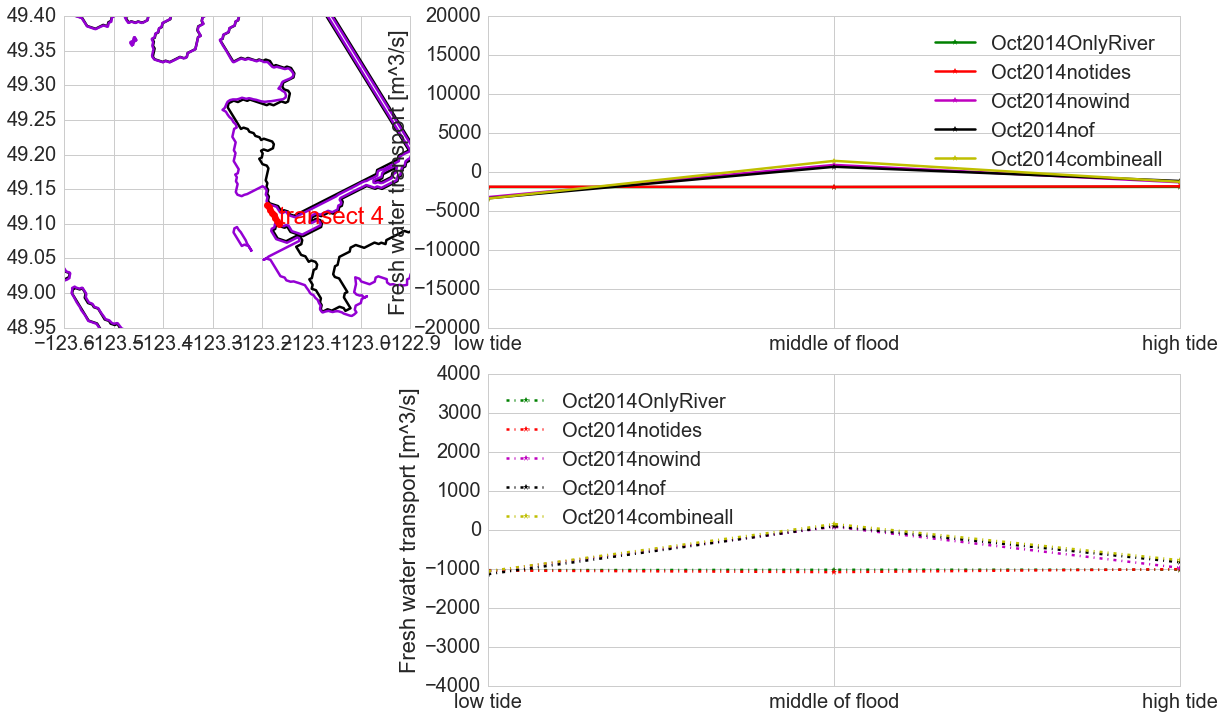

In [29]:
fig = transport_calculate(S,U,V,ssh,lon,lat,depU,depV,'4',fresh_flag = True,y0lim =2e4, y1lim = 4e3)

* Tidal cycle at the river mouth, making river discharge pausing with tides. For onlyriver/notides cases, shear flow still exists in at the transect, with surface layer going northwest, lower layer going eastward into the river.
* Actual flood tide (currents going out of the river) period is very short compared with ebb tide period, magnitude of currents flowing into the river peaks at middle of flood tide and return back at high tide.

In [30]:
## load t_tide
tfile = '/ocean/jieliu/research/meopar/tools/SalishSeaNowcast/\
tidal_predictions/Point Atkinson_t_tide_compare8_31-Dec-2013_02-Dec-2015.csv'
ttide, msl = stormtools.load_tidal_predictions(tfile)

(735507.0, 735538.0)

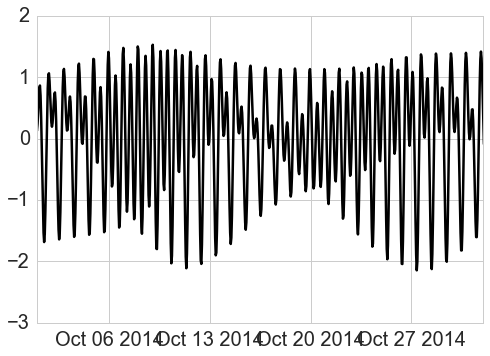

In [31]:
plt.plot(ttide.time,ttide.pred_all,'k-')
plt.xlim([datetime.datetime(2014,10,1),datetime.datetime(2014,11,1)])

max transport of Onlyriver case is  1487.6986069
Integral over time of no wind case is  -344359519.014


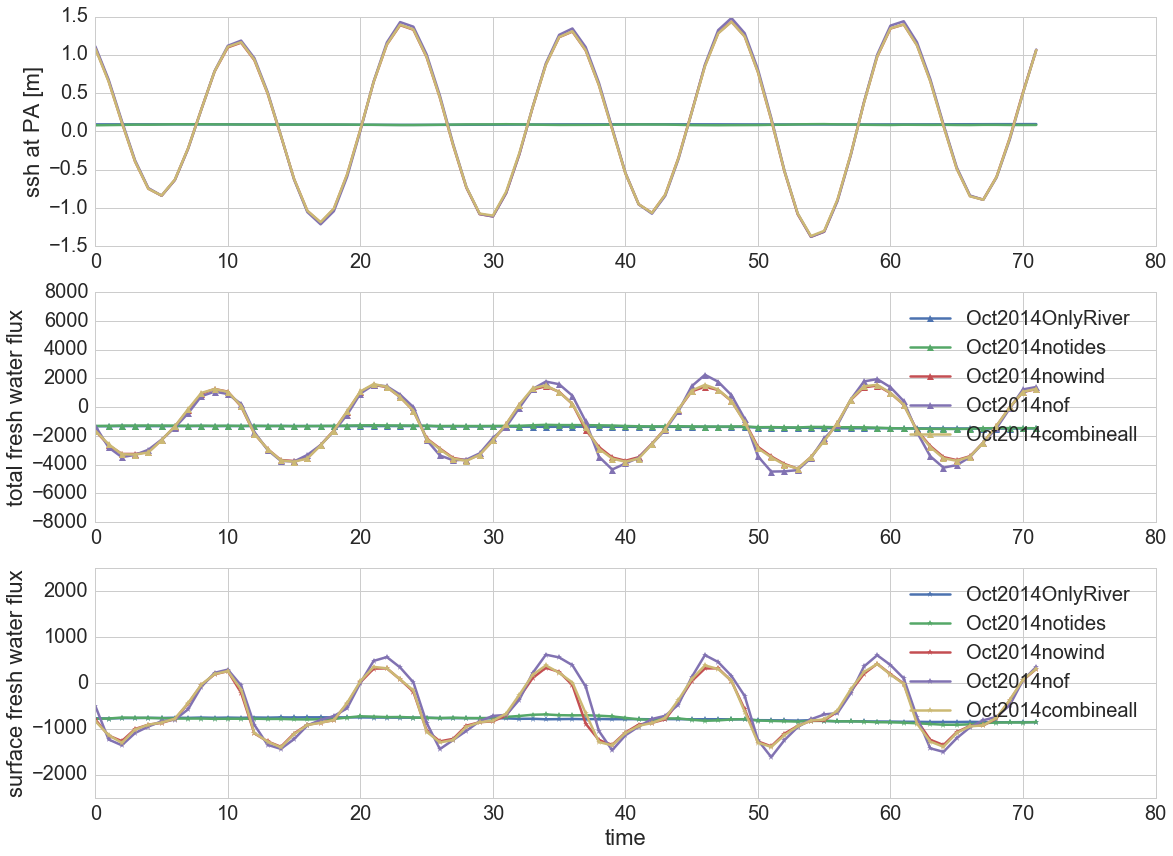

In [32]:
## oct 6-8, spring tides, discharge no more than 2000 m^3/s
plot_series_transport(S,U,V,ssh,lon,lat,depU,depV,'4',120,191,fresh_flag = True)

max transport of Onlyriver case is  2906.26405456
Integral over time of no wind case is  -1262376093.55


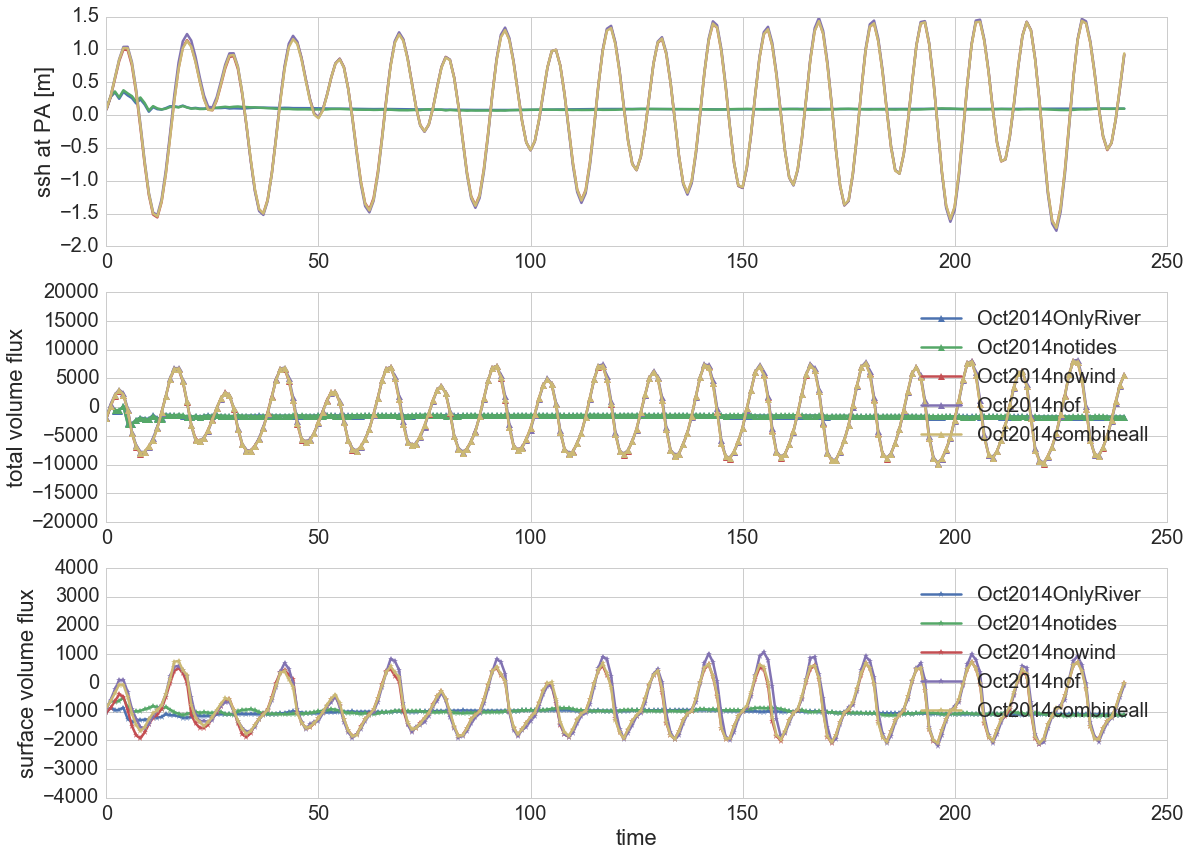

In [33]:
plot_series_transport(S,U,V,ssh,lon,lat,depU,depV,'4',0,240,fresh_flag = False,y1lim = 2e4,y2lim = 4e3)

max transport of Onlyriver case is  2906.26405456
Integral over time of no wind case is  -444789842.814


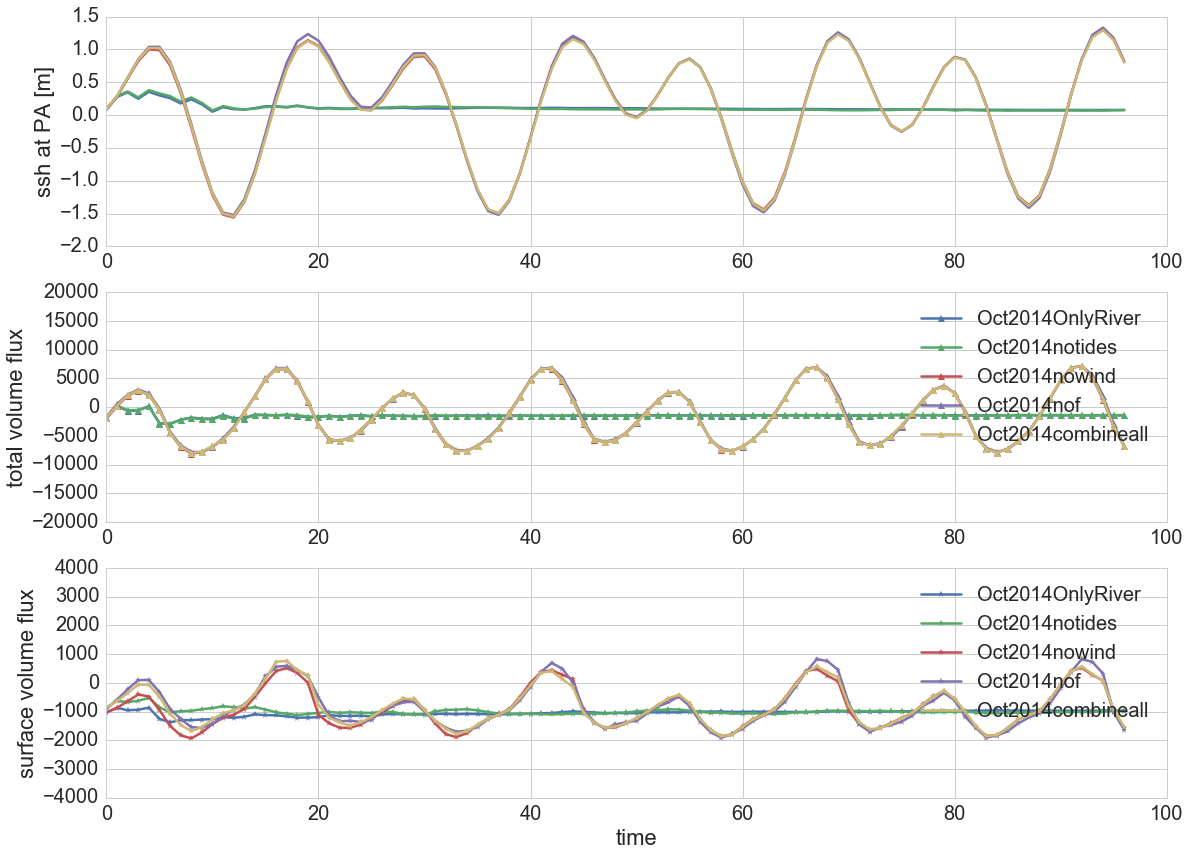

In [34]:
total = plot_series_transport(S,U,V,ssh,lon,lat,depU,depV,'4',0,96,fresh_flag = False,y1lim = 2e4,y2lim = 4e3)

max transport of Onlyriver case is  1632.7379383
Integral over time of no wind case is  -424570227.298


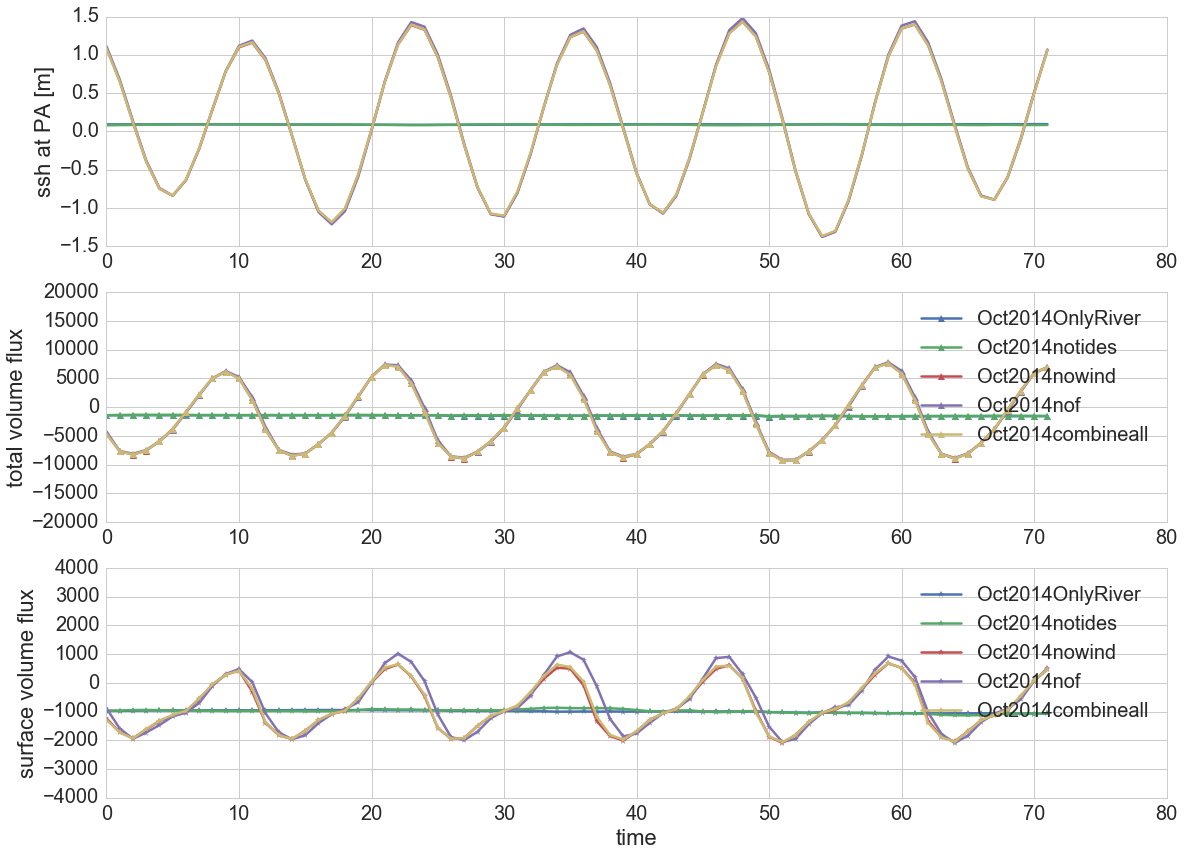

In [35]:
plot_series_transport(S,U,V,ssh,lon,lat,depU,depV,'4',120,191,fresh_flag = False,y1lim = 2e4,y2lim = 4e3)

max transport of Onlyriver case is  0.0
Integral over time of no wind case is  0.0


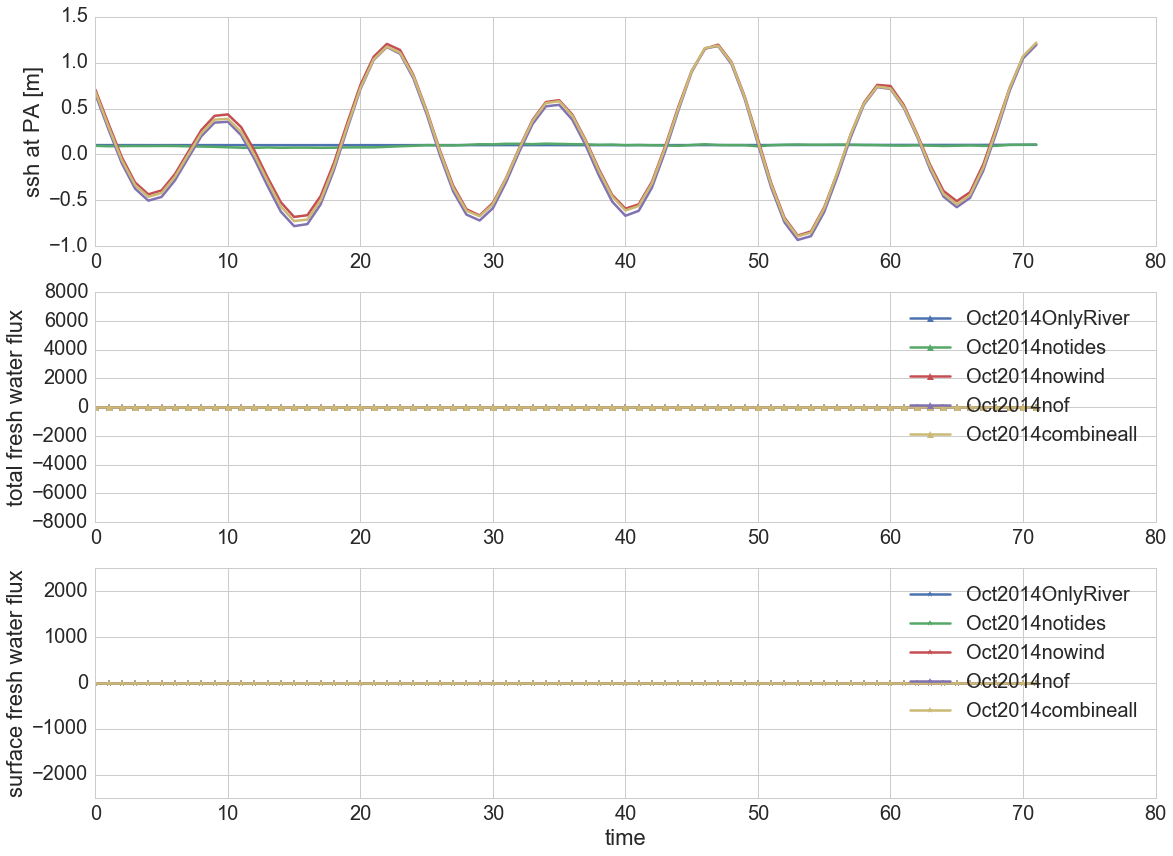

In [36]:
## neap tides, oct 19-21
plot_series_transport(S,U,V,ssh,lon,lat,depU,depV,'5',432,503,fresh_flag = True)

max transport of Onlyriver case is  1721.00158209
Integral over time of no wind case is  -400291948.467


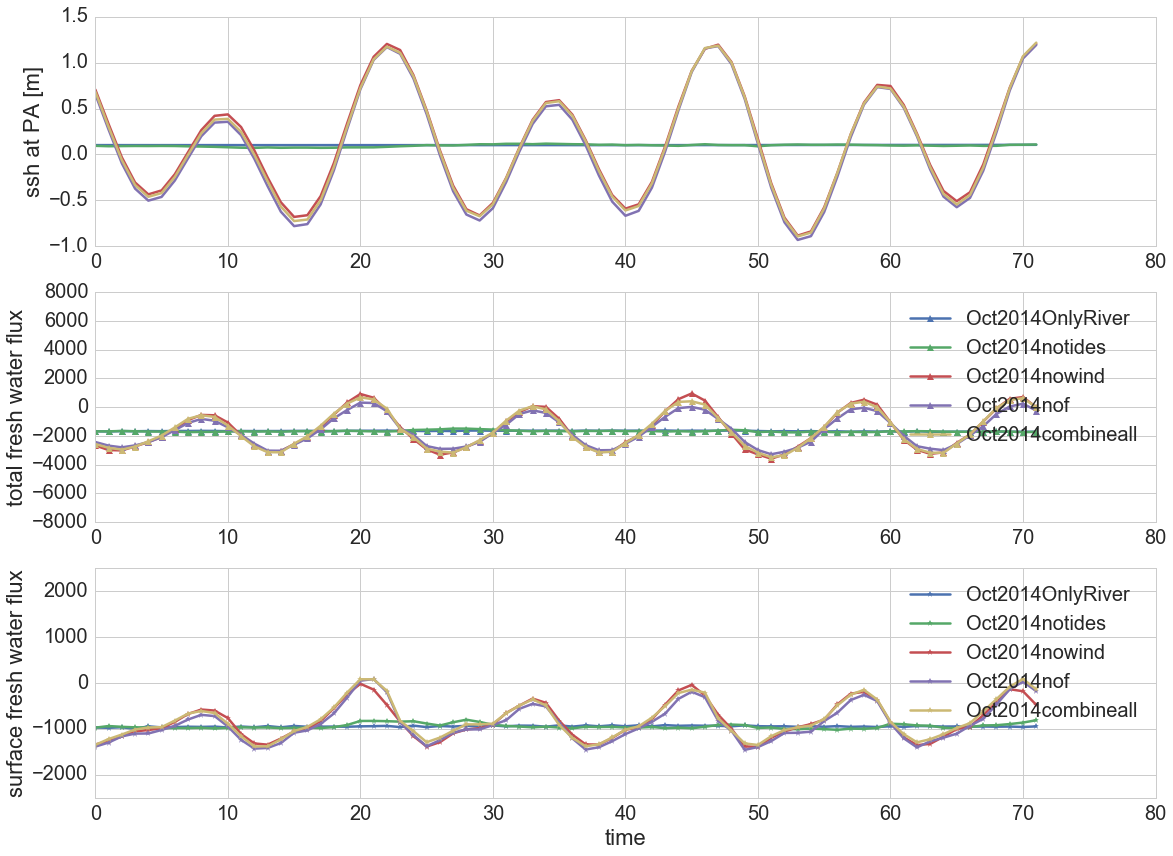

In [37]:
## neap tides, oct 19-21, discharge no more than 2400 m^3/s during these three days
plot_series_transport(S,U,V,ssh,lon,lat,depU,depV,'4',432,503,fresh_flag = True)

* During neap tides, the net surface transport of fresh water is still going outward of the river, no matter flood or ebb tides. Net total transport is slightly going into the river during flood tides.

max transport of Onlyriver case is  1848.09270646
Integral over time of no wind case is  -437198862.019


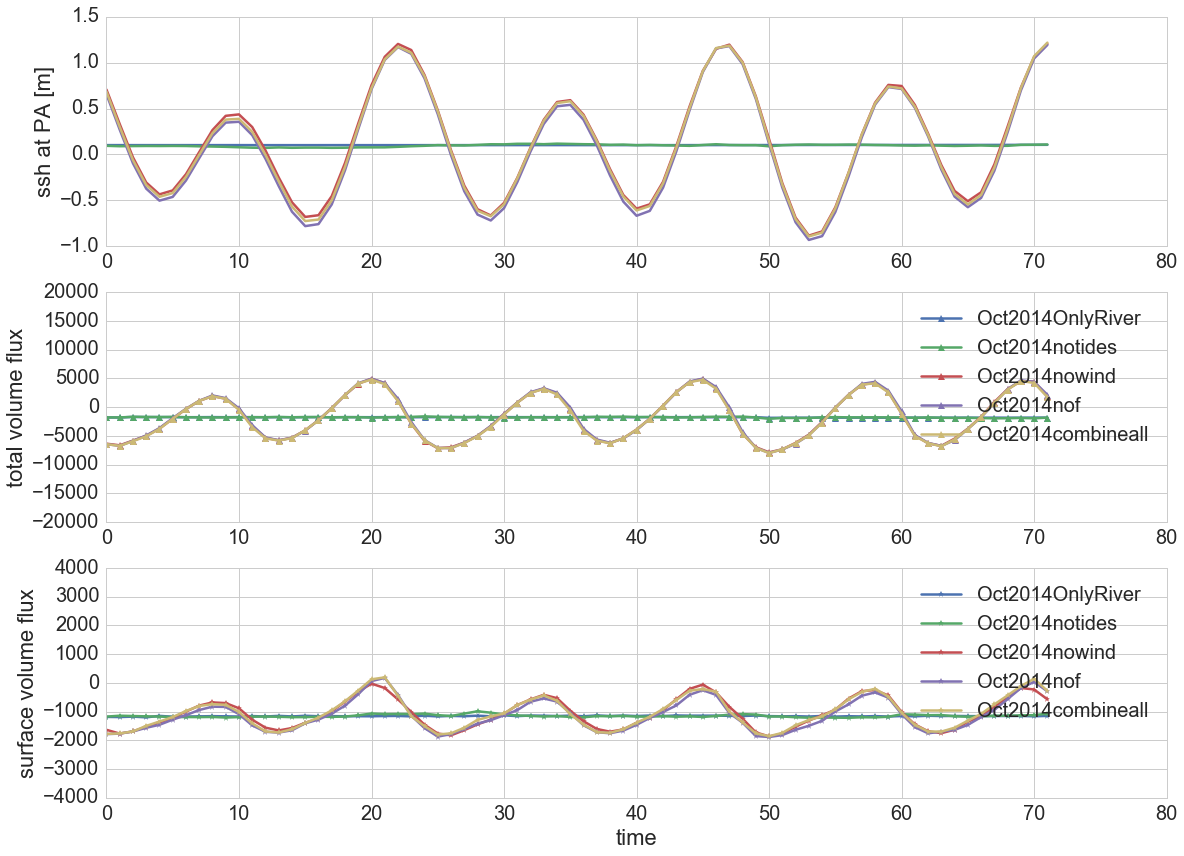

In [38]:
## neap tides, oct 19-21
plot_series_transport(S,U,V,ssh,lon,lat,depU,depV,'4',432,503,fresh_flag = False,y1lim = 2e4,y2lim = 4e3)

max transport of Onlyriver case is  2102.9283532
Integral over time of no wind case is  -137171431.074


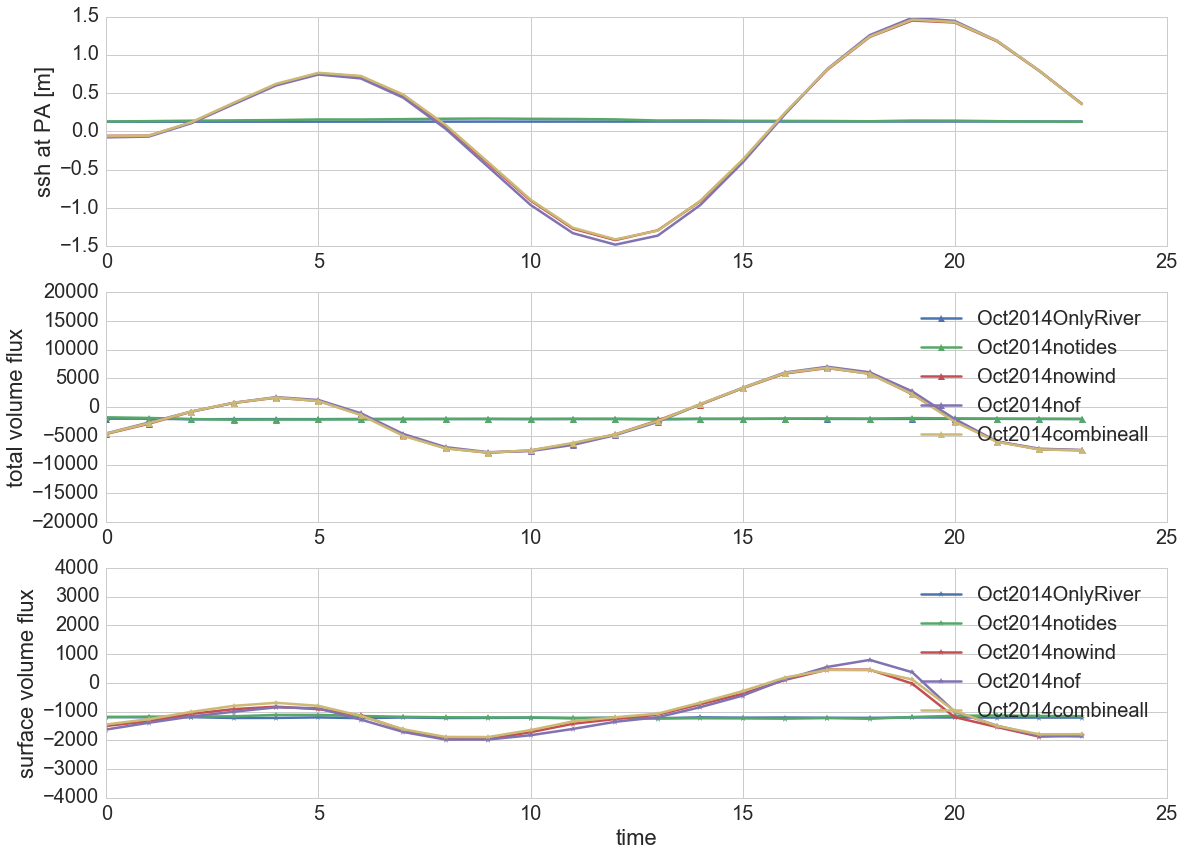

In [39]:
plot_series_transport(S,U,V,ssh,lon,lat,depU,depV,'4',720,743,fresh_flag = False,y1lim = 2e4,y2lim = 4e3)

max transport of Onlyriver case is  2102.9283532
Integral over time of no wind case is  -137171431.074


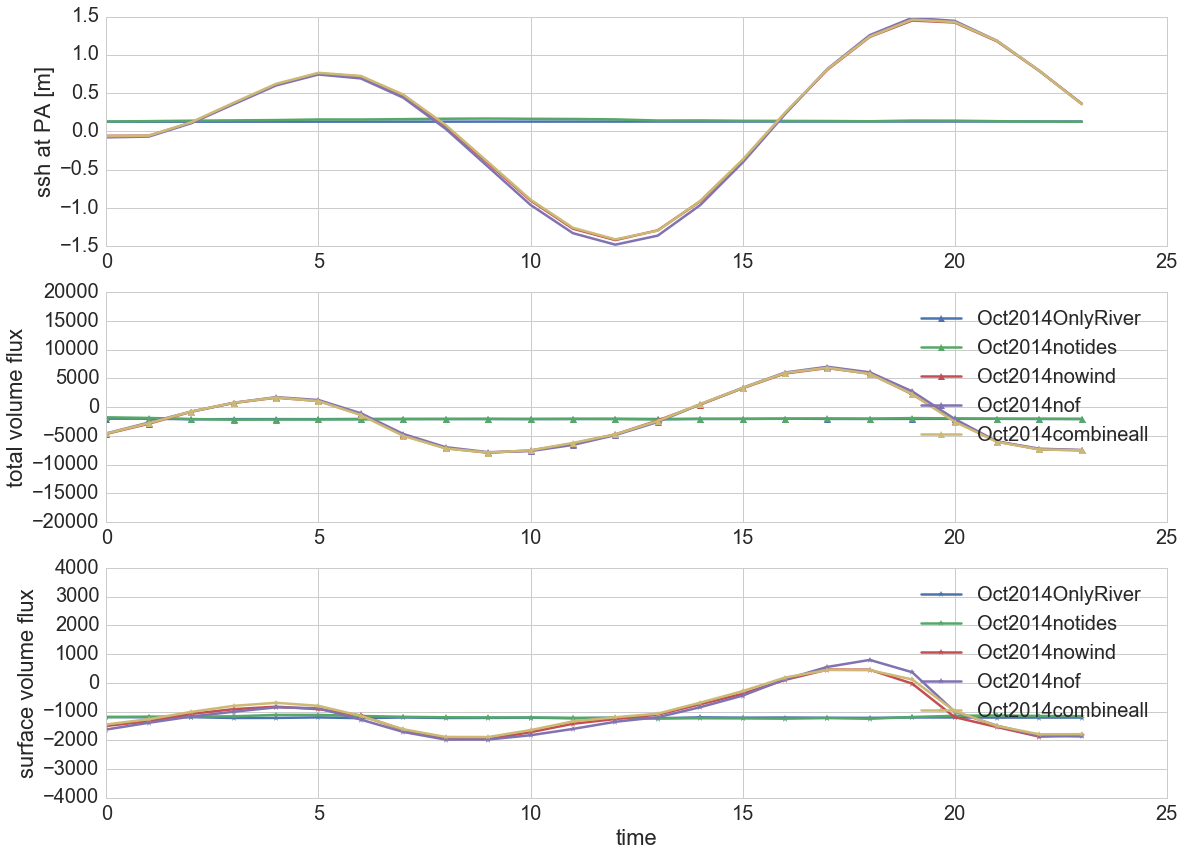

In [40]:
plot_series_transport(S,U,V,ssh,lon,lat,depU,depV,'4',720,743,fresh_flag = False,y1lim = 2e4,y2lim = 4e3)

In [41]:
# get Fraser Flow data
filename = '/data/dlatorne/SOG-projects/SOG-forcing/ECget/Fraser_flow'
fraserflow = np.loadtxt(filename)
fraserflow[366:369]

array([[ 2014.   ,    10.   ,    19.   ,  2229.781],
       [ 2014.   ,    10.   ,    20.   ,  2192.047],
       [ 2014.   ,    10.   ,    21.   ,  2314.256]])